In [ ]:
# !pip install pandasql

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf
import ipywidgets as widgets
from IPython.display import display, clear_output
import re
os.chdir("D:/Users/Desktop/Case 1/Case 1/Data/")

1.	Data– Using functions load the data. your team will use it for that purpose and needs to be easy.


In [4]:
#Read Loans File
df_loans = pd.read_csv('2012_to_2014_loans_data.csv', header=0, 
                       na_values=['NA', 'NA ', 'NA  ', 'NA      ', 'NA    ', 'NA     ', 'NA   '], low_memory=False)
print(df_loans.shape)
df_loans

(1321158, 24)


,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Loan_Purpose_Description,Agency_Code_Description,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag
0,3,84.0,2012,207.00,79.0,54900.0,94,16620.0,1545.0,0000000384,...,Refinance,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y
1,3,84.0,2012,9556.00,43.0,54900.0,133,16620.0,1548.0,0000000384,...,Refinance,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y
2,3,53.0,2012,9556.00,43.0,54900.0,70,16620.0,1548.0,0000000384,...,Refinance,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y
3,3,85.0,2012,206.01,79.0,54900.0,102,16620.0,1935.0,0000000384,...,Refinance,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y
4,3,38.0,2012,107.01,39.0,54900.0,112,16620.0,1492.0,0000000384,...,Purchase,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321153,9,53.0,2014,210.00,19.0,49900.0,16036,13220.0,1056.0,9731400737,...,Refinance,CFPB,First Lien,Conventional,WV,FAYETTE,417.0,Conventional,Jumbo,N
1321154,9,106.0,2014,200.03,550.0,72200.0,31920,47260.0,1363.0,9731400737,...,Purchase,CFPB,First Lien,Conventional,VA,CHESAPEAKE,458.0,Conventional,Jumbo,N
1321155,9,51.0,2014,2111.00,740.0,72200.0,15471,47260.0,182.0,9731400737,...,Refinance,CFPB,First Lien,Conventional,VA,PORTSMOUTH,458.0,Conventional,Jumbo,N
1321156,9,49.0,2014,4223.01,59.0,107100.0,14752,47894.0,703.0,9731400737,...,Refinance,CFPB,First Lien,Conventional,VA,FAIRFAX,625.0,Conventional,Jumbo,N


In [5]:
df_loans.dtypes

Agency_Code                         int64
Applicant_Income_000              float64
As_of_Year                          int64
Census_Tract_Number               float64
County_Code                       float64
FFIEC_Median_Family_Income        float64
Loan_Amount_000                     int64
MSA_MD                            float64
Number_of_Owner_Occupied_Units    float64
Respondent_ID                      object
Sequence_Number                     int64
State_Code                          int64
Tract_to_MSA_MD_Income_Pct        float64
MSA_MD_Description                 object
Loan_Purpose_Description           object
Agency_Code_Description            object
Lien_Status_Description            object
Loan_Type_Description              object
State                              object
County_Name                        object
Conforming_Limit_000              float64
Conventional_Status                object
Conforming_Status                  object
Conventional_Conforming_Flag      

In [6]:
df_loans['Respondent_ID'] = df_loans['Respondent_ID'].astype(str)
df_loans['Respondent_ID'] = df_loans['Respondent_ID'].str.lstrip('0').replace('', '0')

df_loans.head(10)

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Loan_Purpose_Description,Agency_Code_Description,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag
0,3,84.0,2012,207.00,79.0,54900.0,94,16620.0,1545.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y
1,3,84.0,2012,9556.00,43.0,54900.0,133,16620.0,1548.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y
2,3,53.0,2012,9556.00,43.0,54900.0,70,16620.0,1548.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y
3,3,85.0,2012,206.01,79.0,54900.0,102,16620.0,1935.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y
4,3,38.0,2012,107.01,39.0,54900.0,112,16620.0,1492.0,384,...,Purchase,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y
5,3,113.0,2012,206.05,79.0,54900.0,133,16620.0,2493.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y
6,3,91.0,2012,9555.00,43.0,54900.0,192,16620.0,1173.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y
7,3,25.0,2012,121.00,39.0,54900.0,36,16620.0,1361.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y
8,3,111.0,2012,19.02,39.0,54900.0,191,16620.0,1552.0,384,...,Refinance,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y
9,3,70.0,2012,206.05,79.0,54900.0,110,16620.0,2493.0,384,...,Purchase,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y


In [8]:
# Read Institutions File
df_institutions = pd.read_csv('2012_to_2014_institutions_data.csv', header = 0, 
                              na_values = ['NA', 'NA ','NA  ', 'NA      ', 'NA    ','NA     ','NA   '], low_memory=False)
print(df_institutions.shape)
df_institutions.head(10)

(21655, 12)


,As_of_Year,Respondent_ID,Agency_Code,Respondent_Name_TS,Respondent_City_TS,Respondent_State_TS,Respondent_ZIP_Code,Parent_Name_TS,Parent_City_TS,Parent_State_TS,Parent_ZIP_Code,Assets_000_Panel
0,2012,0000000047,1,FIRST FINANCIAL BANK NA,TERRE HAUTE,IN,47802,FIRST FINANCIAL CORPORATION,TERRE HAUTE,IN,47807,2854392
1,2012,0000000056,1,"FIRST FINANCIAL BANK, N.A.",CINCINNATI,OH,45202,NaN,NaN,NaN,NaN,6663427
2,2012,0000000086,1,FIRST NATIONAL BANK OF GERMANT,GERMANTOWN,OH,45327-1349,NaN,NaN,NaN,NaN,52094
3,2012,0000000182,1,EXCHANGE NATIONAL BANK & TRUST,ATCHISON,KS,66002,NaN,NaN,NaN,NaN,330487
4,2012,0000000324,1,FIRST NATIONAL BANK AND TRUST,NEWTOWN,PA,18940,NaN,NaN,NaN,NaN,785017
5,2012,0000000325,1,"FNB BANK, N.A.",DANVILLE,PA,17821,FULTON FINANCIAL CORPORATION,LANCASTER,PA,17604,387250
6,2012,0000000347,1,THE 1ST NATIONAL BANK OF LACON,LACON,IL,61540,NaN,NaN,NaN,NaN,61549
7,2012,0000000497,1,THE FIRST NATIONAL BANK OF SUF,SUFFIELD,CT,06078,"FIRST SUFFIELD FINANCIAL, INC.",SUFFIELD,CT,06078,214349
8,2012,0000000644,1,THE HONESDALE NATIONAL BANK,HONESDALE,PA,18431,NaN,NaN,NaN,NaN,560670
9,2012,0000000661,1,"DNB FIRST, NA",DOWNINGTOWN,PA,19335,NaN,NaN,NaN,NaN,607717


In [9]:
df_institutions.dtypes

As_of_Year              int64
Respondent_ID          object
Agency_Code             int64
Respondent_Name_TS     object
Respondent_City_TS     object
Respondent_State_TS    object
Respondent_ZIP_Code    object
Parent_Name_TS         object
Parent_City_TS         object
Parent_State_TS        object
Parent_ZIP_Code        object
Assets_000_Panel        int64
dtype: object

In [10]:
df_institutions['Respondent_ID'] = df_institutions['Respondent_ID'].astype(str)
df_institutions['Respondent_ID'] = df_institutions['Respondent_ID'].str.lstrip('0')

df_institutions.head(10)

,As_of_Year,Respondent_ID,Agency_Code,Respondent_Name_TS,Respondent_City_TS,Respondent_State_TS,Respondent_ZIP_Code,Parent_Name_TS,Parent_City_TS,Parent_State_TS,Parent_ZIP_Code,Assets_000_Panel
0,2012,47,1,FIRST FINANCIAL BANK NA,TERRE HAUTE,IN,47802,FIRST FINANCIAL CORPORATION,TERRE HAUTE,IN,47807,2854392
1,2012,56,1,"FIRST FINANCIAL BANK, N.A.",CINCINNATI,OH,45202,NaN,NaN,NaN,NaN,6663427
2,2012,86,1,FIRST NATIONAL BANK OF GERMANT,GERMANTOWN,OH,45327-1349,NaN,NaN,NaN,NaN,52094
3,2012,182,1,EXCHANGE NATIONAL BANK & TRUST,ATCHISON,KS,66002,NaN,NaN,NaN,NaN,330487
4,2012,324,1,FIRST NATIONAL BANK AND TRUST,NEWTOWN,PA,18940,NaN,NaN,NaN,NaN,785017
5,2012,325,1,"FNB BANK, N.A.",DANVILLE,PA,17821,FULTON FINANCIAL CORPORATION,LANCASTER,PA,17604,387250
6,2012,347,1,THE 1ST NATIONAL BANK OF LACON,LACON,IL,61540,NaN,NaN,NaN,NaN,61549
7,2012,497,1,THE FIRST NATIONAL BANK OF SUF,SUFFIELD,CT,06078,"FIRST SUFFIELD FINANCIAL, INC.",SUFFIELD,CT,06078,214349
8,2012,644,1,THE HONESDALE NATIONAL BANK,HONESDALE,PA,18431,NaN,NaN,NaN,NaN,560670
9,2012,661,1,"DNB FIRST, NA",DOWNINGTOWN,PA,19335,NaN,NaN,NaN,NaN,607717


a. Merge the application data with institution data such that each loan application is assigned a “Respondent_Name”

In [11]:
# Merge Datasets
new_df = df_loans.copy()
new_df = new_df.merge(df_institutions[['Respondent_ID', 'Agency_Code', 'As_of_Year', 'Respondent_Name_TS']], how = 'left', on = ['Respondent_ID', 'Agency_Code', 'As_of_Year'])
print(new_df.shape)
new_df.head(10)

(1321158, 25)


,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Agency_Code_Description,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS
0,3,84.0,2012,207.00,79.0,54900.0,94,16620.0,1545.0,384,...,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
1,3,84.0,2012,9556.00,43.0,54900.0,133,16620.0,1548.0,384,...,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
2,3,53.0,2012,9556.00,43.0,54900.0,70,16620.0,1548.0,384,...,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
3,3,85.0,2012,206.01,79.0,54900.0,102,16620.0,1935.0,384,...,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
4,3,38.0,2012,107.01,39.0,54900.0,112,16620.0,1492.0,384,...,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
5,3,113.0,2012,206.05,79.0,54900.0,133,16620.0,2493.0,384,...,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
6,3,91.0,2012,9555.00,43.0,54900.0,192,16620.0,1173.0,384,...,FDIC,First Lien,Conventional,WV,LINCOLN,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
7,3,25.0,2012,121.00,39.0,54900.0,36,16620.0,1361.0,384,...,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
8,3,111.0,2012,19.02,39.0,54900.0,191,16620.0,1552.0,384,...,FDIC,First Lien,Conventional,WV,KANAWHA,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY
9,3,70.0,2012,206.05,79.0,54900.0,110,16620.0,2493.0,384,...,FDIC,First Lien,Conventional,WV,PUTNAM,417.0,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY


In [12]:
new_df[new_df['Respondent_Name_TS'].isnull()]

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Agency_Code_Description,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS


 Additionally, create a new attribute that buckets “Loan_Amount_000” into reasonable groups.


In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
new_df['Loan_Amount_000'].describe()

count   1321158.00
mean        290.23
std         965.78
min           1.00
25%         153.00
50%         235.00
75%         347.00
max       99625.00
Name: Loan_Amount_000, dtype: float64

Text(0, 0.5, 'Values')

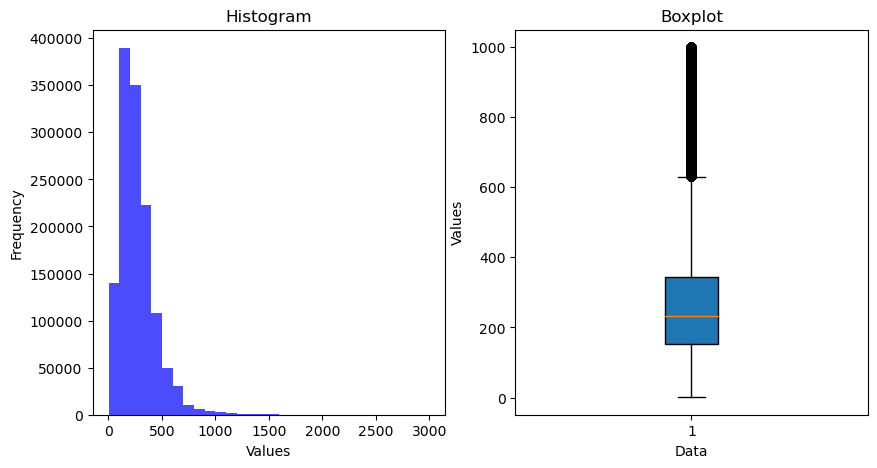

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

axes[0].hist(new_df[new_df['Loan_Amount_000'] < 3000]['Loan_Amount_000'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(new_df[new_df['Loan_Amount_000'] < 1000]['Loan_Amount_000'], vert=True, patch_artist=True) 
axes[1].set_title('Boxplot')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Values')

(array([ 10344.,  16895.,  37453.,  55707.,  70486.,  86875.,  95133.,
        100206.,  94915.,  88543.,  85510.,  78381.,  66229.,  57751.,
         50578.,  49640.,  46413.,  66079.,  14024.,  16091.,  15857.,
         17153.,  13025.,  11076.,  10351.,  10021.,  15781.,   4166.,
          3415.,   3319.]),
 array([  1.        ,  24.26666667,  47.53333333,  70.8       ,
         94.06666667, 117.33333333, 140.6       , 163.86666667,
        187.13333333, 210.4       , 233.66666667, 256.93333333,
        280.2       , 303.46666667, 326.73333333, 350.        ,
        373.26666667, 396.53333333, 419.8       , 443.06666667,
        466.33333333, 489.6       , 512.86666667, 536.13333333,
        559.4       , 582.66666667, 605.93333333, 629.2       ,
        652.46666667, 675.73333333, 699.        ]),
 <BarContainer object of 30 artists>)

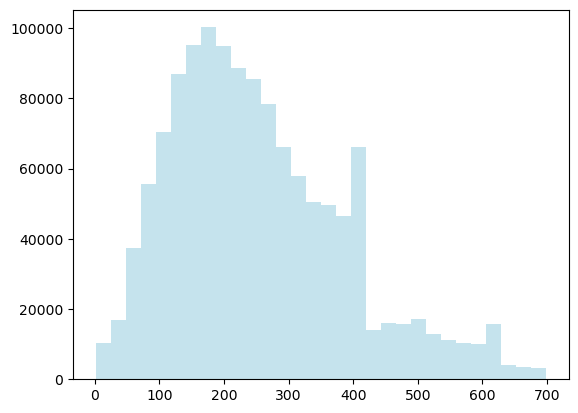

In [15]:
plt.hist(new_df[new_df['Loan_Amount_000'] < 700]['Loan_Amount_000'], bins=30, color='lightblue', alpha=0.7)

In [16]:
labels = ['Small', 'Medium', 'Large', 'Very Large']
new_df['Loan_Group'] = pd.qcut(new_df['Loan_Amount_000'], q=[0, 0.4, 0.65, 0.95, 1.0], labels=labels)
new_df['Loan_Group']

0               Small
1               Small
2               Small
3               Small
4               Small
              ...    
1321153    Very Large
1321154    Very Large
1321155    Very Large
1321156    Very Large
1321157    Very Large
Name: Loan_Group, Length: 1321158, dtype: category
Categories (4, object): ['Small' < 'Medium' < 'Large' < 'Very Large']

In [17]:
new_df

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS,Loan_Group
0,3,84.00,2012,207.00,79.00,54900.00,94,16620.00,1545.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
1,3,84.00,2012,9556.00,43.00,54900.00,133,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
2,3,53.00,2012,9556.00,43.00,54900.00,70,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
3,3,85.00,2012,206.01,79.00,54900.00,102,16620.00,1935.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
4,3,38.00,2012,107.01,39.00,54900.00,112,16620.00,1492.00,384,...,First Lien,Conventional,WV,KANAWHA,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321153,9,53.00,2014,210.00,19.00,49900.00,16036,13220.00,1056.00,9731400737,...,First Lien,Conventional,WV,FAYETTE,417.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large
1321154,9,106.00,2014,200.03,550.00,72200.00,31920,47260.00,1363.00,9731400737,...,First Lien,Conventional,VA,CHESAPEAKE,458.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large
1321155,9,51.00,2014,2111.00,740.00,72200.00,15471,47260.00,182.00,9731400737,...,First Lien,Conventional,VA,PORTSMOUTH,458.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large
1321156,9,49.00,2014,4223.01,59.00,107100.00,14752,47894.00,703.00,9731400737,...,First Lien,Conventional,VA,FAIRFAX,625.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large


i.	hmda_init() – Read the data files and return a pointer or object containing the expanded HMDA data from part a.


In [20]:
def hmda_init():
    df_loans = pd.read_csv('2012_to_2014_loans_data.csv', header = 0, na_values = ['NA', 'NA ','NA  ', 'NA      ', 'NA    ','NA     ','NA   '], low_memory = False)
    df_loans['Respondent_ID'] = df_loans['Respondent_ID'].astype(str)
    df_loans['Respondent_ID'] = df_loans['Respondent_ID'].str.lstrip('0').replace('', '0')
    
    df_institutions = pd.read_csv('2012_to_2014_institutions_data.csv', header = 0, na_values = ['NA', 'NA ','NA  ', 'NA      ', 'NA    ','NA     ','NA   '], low_memory = False)
    df_institutions['Respondent_ID'] = df_institutions['Respondent_ID'].astype(str)
    df_institutions['Respondent_ID'] = df_institutions['Respondent_ID'].str.lstrip('0')

    new_df = df_loans.merge(df_institutions[['Respondent_ID', 'Agency_Code', 'As_of_Year', 'Respondent_Name_TS']], how = 'left', on = ['Respondent_ID', 'Agency_Code', 'As_of_Year'])
    
    labels = ['Small', 'Medium', 'Large', 'Very Large']
    new_df['Loan_Group'] = pd.qcut(new_df['Loan_Amount_000'], q=[0, 0.4, 0.65, 0.95, 1.0], labels=labels)
    
    return new_df

In [21]:
df = hmda_init() 
df

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS,Loan_Group
0,3,84.00,2012,207.00,79.00,54900.00,94,16620.00,1545.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
1,3,84.00,2012,9556.00,43.00,54900.00,133,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
2,3,53.00,2012,9556.00,43.00,54900.00,70,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
3,3,85.00,2012,206.01,79.00,54900.00,102,16620.00,1935.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
4,3,38.00,2012,107.01,39.00,54900.00,112,16620.00,1492.00,384,...,First Lien,Conventional,WV,KANAWHA,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321153,9,53.00,2014,210.00,19.00,49900.00,16036,13220.00,1056.00,9731400737,...,First Lien,Conventional,WV,FAYETTE,417.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large
1321154,9,106.00,2014,200.03,550.00,72200.00,31920,47260.00,1363.00,9731400737,...,First Lien,Conventional,VA,CHESAPEAKE,458.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large
1321155,9,51.00,2014,2111.00,740.00,72200.00,15471,47260.00,182.00,9731400737,...,First Lien,Conventional,VA,PORTSMOUTH,458.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large
1321156,9,49.00,2014,4223.01,59.00,107100.00,14752,47894.00,703.00,9731400737,...,First Lien,Conventional,VA,FAIRFAX,625.00,Conventional,Jumbo,N,MEGACHANGE MORTGAGE,Very Large


In [22]:
df.dtypes

Agency_Code                          int64
Applicant_Income_000               float64
As_of_Year                           int64
Census_Tract_Number                float64
County_Code                        float64
FFIEC_Median_Family_Income         float64
Loan_Amount_000                      int64
MSA_MD                             float64
Number_of_Owner_Occupied_Units     float64
Respondent_ID                       object
Sequence_Number                      int64
State_Code                           int64
Tract_to_MSA_MD_Income_Pct         float64
MSA_MD_Description                  object
Loan_Purpose_Description            object
Agency_Code_Description             object
Lien_Status_Description             object
Loan_Type_Description               object
State                               object
County_Name                         object
Conforming_Limit_000               float64
Conventional_Status                 object
Conforming_Status                   object
Conventiona

ii. SQL – Write the following queries based on the tables provided.

1.	In the same view show the rank the agencies based on loan amount and rank by number of parent zip codes where they have provided loans

In [23]:
run_query = lambda query: sqldf(query, globals())
q = """
    SELECT a.Agency_Code, SUM(a.Loan_Amount_000) AS Total_Loan_Amount_000, m.Unique_Zip_Count
    FROM df a
    JOIN (
          SELECT Agency_Code, COUNT(DISTINCT Parent_ZIP_Code) AS Unique_Zip_Count
          FROM df_institutions
          GROUP BY Agency_Code
          ) m
          ON a.Agency_Code = m.Agency_Code
    GROUP BY a.Agency_Code
    ORDER BY Unique_Zip_Count DESC;
    """

result_1 = run_query(q)
result_1

,Agency_Code,Total_Loan_Amount_000,Unique_Zip_Count
0,3,29260076,1138
1,1,15148518,517
2,2,21926722,304
3,5,10774334,233
4,7,132863024,190
5,9,173471123,91


2.	Show the three largest loan amounts per county and the average of the county (repeated for each loan amount)


In [25]:
q_2 = """
    SELECT a.County_Name, a.Loan_Amount_000, a.rank, Avg_Loan_Amount_000
    FROM (
        SELECT County_Name, Loan_Amount_000, row_number() over (partition by County_Name order by Loan_Amount_000 desc) as rank 
        FROM df
        WHERE County_Name NOT IN ('None')
        ) a 
    LEFT JOIN (
               SELECT County_Name, AVG(Loan_Amount_000) AS Avg_Loan_Amount_000
               FROM df
               WHERE County_Name NOT IN ('None')
               GROUP BY County_Name) b
    ON a.County_Name = b.County_Name
    WHERE RANK <= 3;
    """
  
result_2 = run_query(q_2)
result_2

,County_Name,Loan_Amount_000,rank,Avg_Loan_Amount_000
0,ACCOMACK,1455,1,161.67
1,ACCOMACK,750,2,161.67
2,ACCOMACK,710,3,161.67
3,ALBEMARLE,65750,1,311.74
4,ALBEMARLE,60419,2,311.74
...,...,...,...,...
625,WYTHE,38041,2,243.06
626,WYTHE,19408,3,243.06
627,YORK,40745,1,282.84
628,YORK,37523,2,282.84


2.	Quality – wrong data is worse than no data at all
a.	Perform quality assessment on those Loan_Amount_000 and Respondent_Name. Do not stop at descriptive analytics; produce guidelines or techniques for quality check that can be applied.

* Loan_Amount_000

To review our variable, we will examine its distribution to ensure there are no negative values. Additionally, we will assess its completeness to verify that we are working with a clean and reliable variable, given its importance. This thorough examination will help us maintain the integrity of our analysis and ensure accurate results.

In [26]:
df['Loan_Amount_000'].describe()

count   1321158.00
mean        290.23
std         965.78
min           1.00
25%         153.00
50%         235.00
75%         347.00
max       99625.00
Name: Loan_Amount_000, dtype: float64

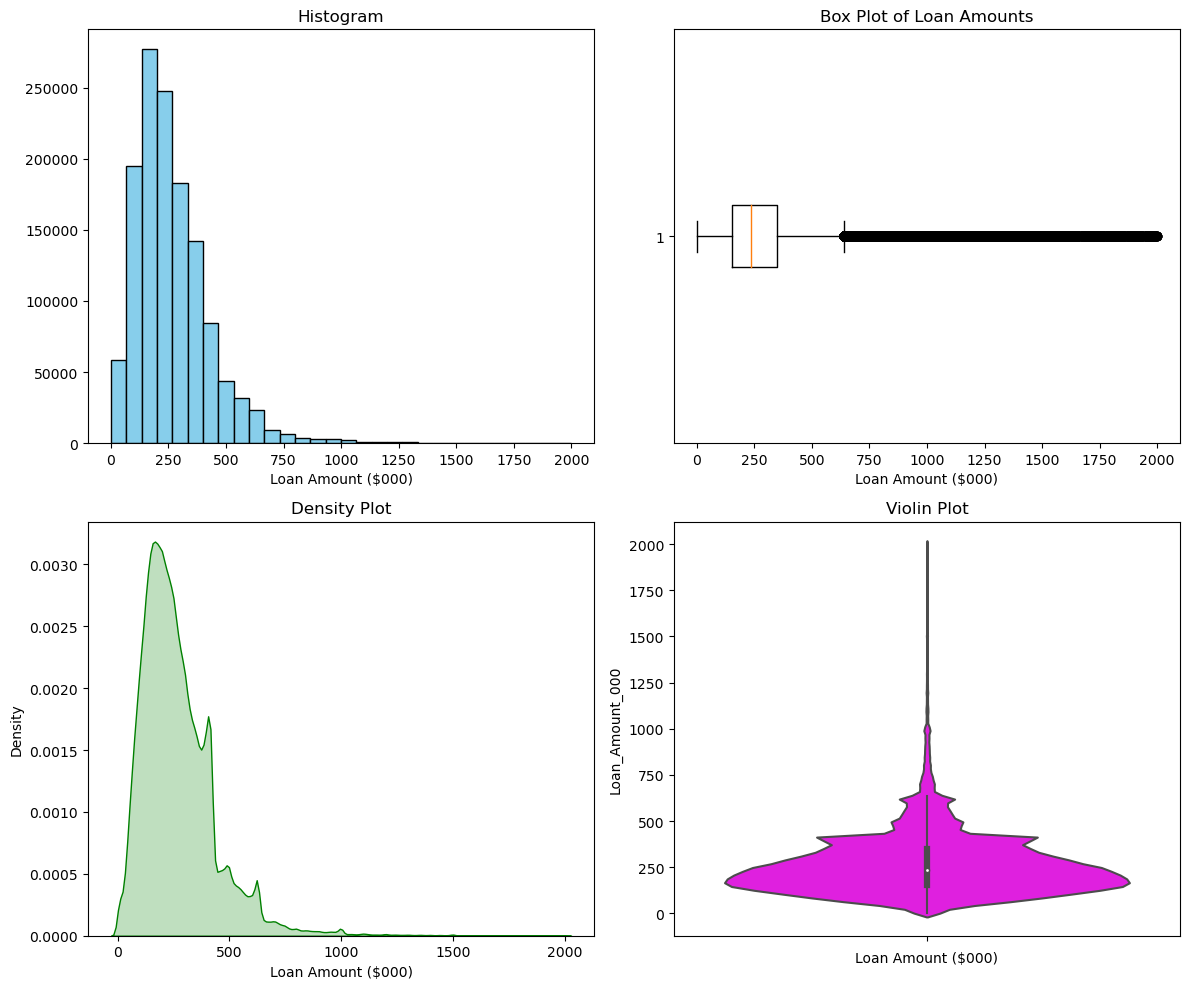

In [28]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(df[df['Loan_Amount_000'] < 2000]['Loan_Amount_000'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Loan Amount ($000)')

plt.subplot(2, 2, 2)
plt.boxplot(df[df['Loan_Amount_000'] < 2000]['Loan_Amount_000'], vert=False)
plt.title('Box Plot of Loan Amounts')
plt.xlabel('Loan Amount ($000)')

plt.subplot(2, 2, 3)
sns.kdeplot(df[df['Loan_Amount_000'] < 2000]['Loan_Amount_000'], fill=True, color='green')
plt.title('Density Plot')
plt.xlabel('Loan Amount ($000)')

plt.subplot(2, 2, 4)
sns.violinplot(y=df[df['Loan_Amount_000'] < 2000]['Loan_Amount_000'], color='magenta')
plt.title('Violin Plot')
plt.xlabel('Loan Amount ($000)')

plt.tight_layout()
plt.show()

In [29]:
def quality_check(df, column_name):
    
    negative_values = df[(df[column_name] < 0)][column_name]
    
    null_values = df[df[column_name].isnull()][column_name]
    
    not_numeric_values = df[~df[column_name].apply(lambda x: isinstance(x, (int, float)))][column_name]

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[df[column_name] > upper_bound][column_name]
    
    null_sum = df[column_name].isnull().sum()
    completeness = (1-null_sum/df.shape[0])*100
    
    return{
        'negative_values': negative_values,
        'null_values': null_values,
        'not_numeric_values': not_numeric_values,
        'outliers': outliers,
        'completeness': completeness
    }

In [30]:
check_loan = quality_check(df, 'Loan_Amount_000')
print("Negative Values", check_loan['negative_values'].shape[0])
print(check_loan['negative_values'])
print("\nNull Values", check_loan['null_values'].shape[0])
print(check_loan['null_values'])
print("\nNon-numeric Values", check_loan['not_numeric_values'].shape[0])
print(check_loan['not_numeric_values'])
print("\nOutliers", check_loan['outliers'].shape[0])
print(check_loan['outliers'])
print("\nCompleteness Percentage")
print(check_loan['completeness'])

Negative Values 0
Series([], Name: Loan_Amount_000, dtype: int64)

Null Values 0
Series([], Name: Loan_Amount_000, dtype: int64)

Non-numeric Values 0
Series([], Name: Loan_Amount_000, dtype: int64)

Outliers 38983
102          990
691         1210
694          945
811          652
915         1000
           ...  
1321153    16036
1321154    31920
1321155    15471
1321156    14752
1321157    13719
Name: Loan_Amount_000, Length: 38983, dtype: int64

Completeness Percentage
100.0


Text(0.5, 0, 'Outliers Loan Amount ($000)')

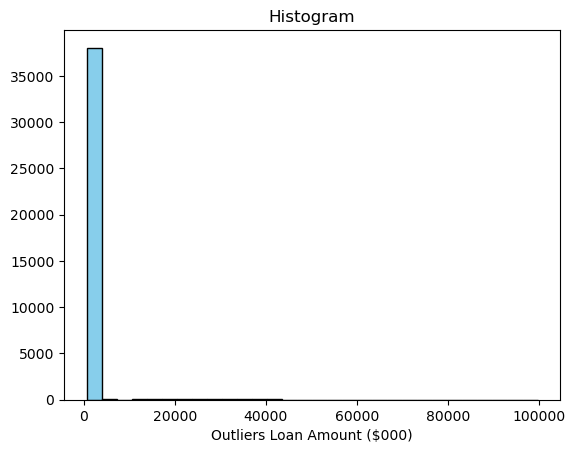

In [31]:
plt.hist(check_loan['outliers'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Outliers Loan Amount ($000)')

In [32]:
#Copy df
df_copy_2 = df.copy()
df_copy_2 = df_copy_2.drop(list(check_loan['outliers'].index))
df_copy_2

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS,Loan_Group
0,3,84.00,2012,207.00,79.00,54900.00,94,16620.00,1545.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
1,3,84.00,2012,9556.00,43.00,54900.00,133,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
2,3,53.00,2012,9556.00,43.00,54900.00,70,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
3,3,85.00,2012,206.01,79.00,54900.00,102,16620.00,1935.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
4,3,38.00,2012,107.01,39.00,54900.00,112,16620.00,1492.00,384,...,First Lien,Conventional,WV,KANAWHA,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320853,7,115.00,2014,2004.00,175.00,52000.00,323,NaN,1686.00,95-4623407,...,First Lien,VA guaranteed,VA,SOUTHAMPTON,417.00,Non-Conventional,Conforming,N,PROSPECT MORTGAGE LLC,Large
1320854,7,71.00,2014,203.00,133.00,52000.00,241,NaN,2135.00,95-4623407,...,First Lien,FHA insured,VA,NORTHUMBERLAND,417.00,Non-Conventional,Conforming,N,PROSPECT MORTGAGE LLC,Medium
1320855,7,24.00,2014,9501.00,109.00,52000.00,77,NaN,2326.00,95-4623407,...,First Lien,FHA insured,VA,LOUISA,535.00,Non-Conventional,Conforming,N,PROSPECT MORTGAGE LLC,Small
1320856,7,43.00,2014,401.00,171.00,52000.00,126,NaN,2112.00,95-4623407,...,First Lien,FHA insured,VA,SHENANDOAH,417.00,Non-Conventional,Conforming,N,PROSPECT MORTGAGE LLC,Small


In [33]:
labels = ['Small', 'Medium', 'Large', 'Very Large']
df_copy_2['Loan_Group'] = pd.qcut(new_df['Loan_Amount_000'], q=[0, 0.25, 0.5, 0.75, 1.0], labels=labels)
df_copy_2['Loan_Group']

0          Small
1          Small
2          Small
3          Small
4          Small
           ...  
1320853    Large
1320854    Large
1320855    Small
1320856    Small
1320857    Small
Name: Loan_Group, Length: 1282175, dtype: category
Categories (4, object): ['Small' < 'Medium' < 'Large' < 'Very Large']

* Respondent Name

Given that it is a character-type variable, we will review patterns in the names of the institutions and clean any signs or characters that do not conform to the established format. This will help maintain consistency and accuracy in our data.

In [34]:
def quality_check_2(df, column_name):
    df_copy = df.copy()

    null_values = df_copy[df_copy[column_name].isnull()][column_name]
    
    df_copy[column_name] = df_copy[column_name].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df_copy[column_name] = df_copy[column_name].str.upper().str.strip()

    df_copy['Name_Length'] = df_copy[column_name].str.len()
    anomalies = df_copy[(df_copy['Name_Length'] < 7)|
                        (df_copy['Name_Length'] > 35)][column_name]
    
    digit_values = df_copy[df_copy[column_name].astype(str).str.isdigit()][column_name]
    
    df_cleaned = df_copy.drop('Name_Length', axis = 1)
    
    return {
        'null_values': null_values, 
        'anomalies': anomalies,
        'cleaned_df': df_cleaned,
        'digit_values': digit_values
    }

In [35]:
result_institutions = quality_check_2(df_copy_2, 'Respondent_Name_TS')
print("Null Values", result_institutions['null_values'].shape[0])
print(result_institutions['null_values'])
print("\nAnomalies", result_institutions['anomalies'].shape[0])
print(result_institutions['anomalies'].value_counts())
print("\nDigit Values", result_institutions['digit_values'].shape[0])
print(result_institutions['digit_values'])

Null Values 0
Series([], Name: Respondent_Name_TS, dtype: object)

Anomalies 33093
Respondent_Name_TS
NFCU      32813
CNB         106
SCBT         80
EVB          41
UNFCU        17
AHMC         10
MECU          9
GEEFCU        5
NNMECU        4
OEFCU         2
ACOPIA        2
CFBANK        1
GFCU          1
FNCB          1
NCUA          1
Name: count, dtype: int64

Digit Values 0
Series([], Name: Respondent_Name_TS, dtype: object)


In [36]:
df_copy_2 = result_institutions['cleaned_df']
print(df_copy_2.shape)
df_copy_2.head()

(1282175, 26)


,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS,Loan_Group
0,3,84.00,2012,207.00,79.00,54900.00,94,16620.00,1545.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
1,3,84.00,2012,9556.00,43.00,54900.00,133,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
2,3,53.00,2012,9556.00,43.00,54900.00,70,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
3,3,85.00,2012,206.01,79.00,54900.00,102,16620.00,1935.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
4,3,38.00,2012,107.01,39.00,54900.00,112,16620.00,1492.00,384,...,First Lien,Conventional,WV,KANAWHA,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small


We have checked for null values in our column, standardized the format for all data, and reviewed names that may be erroneous or contain only numbers. To continue with the review of the names, it is essential to ensure that these institutions are found in a database of permitted financial institution names.

b. What other attributes (1 or 2) are relevant to keep regular quality check, why?


To make the loan approval decision, we primarily rely on the applicant's purchasing power, represented in our case by 'Applicant_Income_000'. Therefore, we will conduct an analysis to ensure that the data quality in this column is accurate and reliable.

* Applicant_Income_000

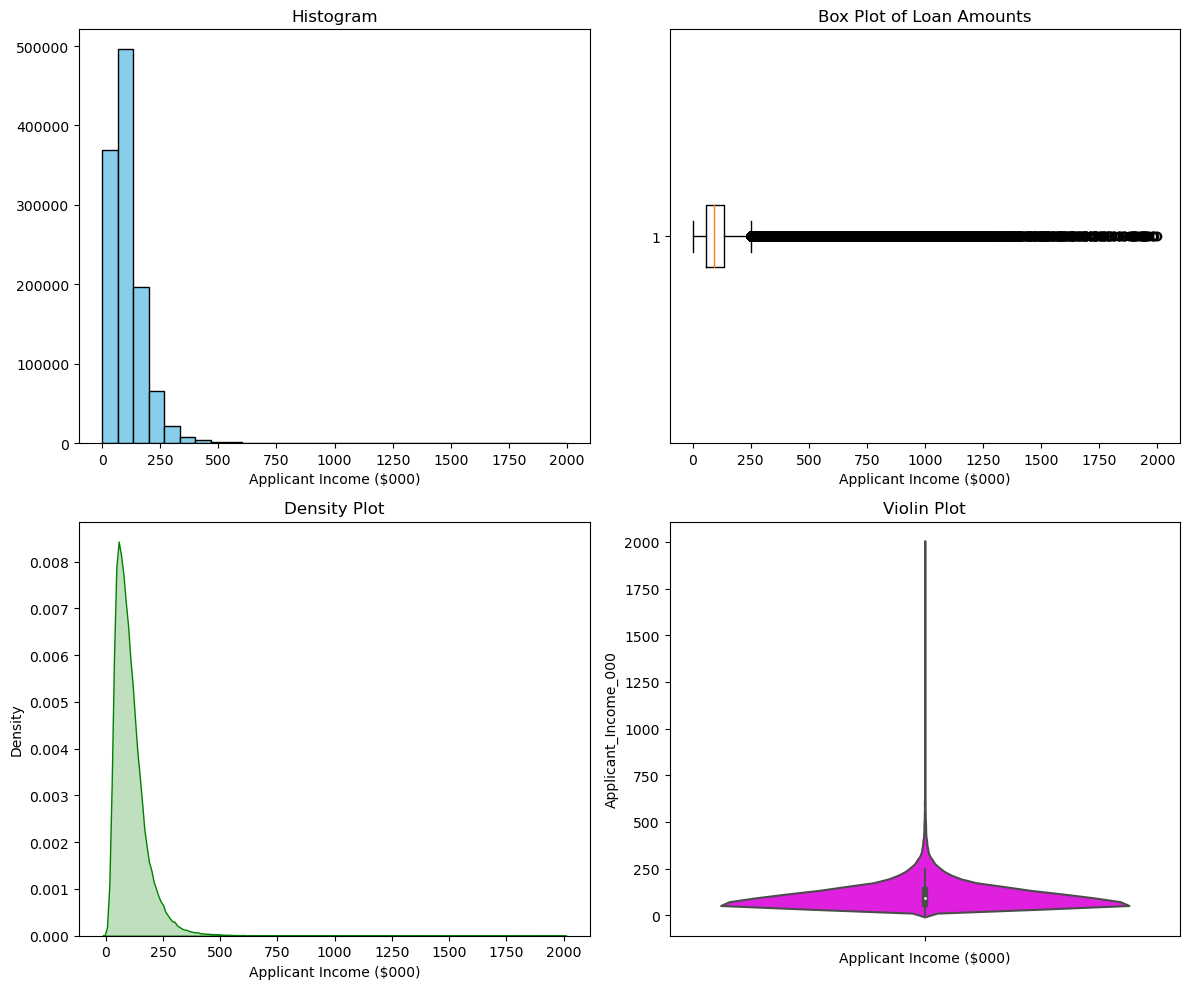

In [38]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(df_copy_2[df_copy_2['Applicant_Income_000'] < 2000]['Applicant_Income_000'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Applicant Income ($000)')

plt.subplot(2, 2, 2)
plt.boxplot(df_copy_2[df_copy_2['Applicant_Income_000'] < 2000]['Applicant_Income_000'], vert=False)
plt.title('Box Plot of Loan Amounts')
plt.xlabel('Applicant Income ($000)')

plt.subplot(2, 2, 3)
sns.kdeplot(df_copy_2[df_copy_2['Applicant_Income_000'] < 2000]['Applicant_Income_000'], fill=True, color='green')
plt.title('Density Plot')
plt.xlabel('Applicant Income ($000)')

plt.subplot(2, 2, 4)
sns.violinplot(y=df_copy_2[df_copy_2['Applicant_Income_000'] < 2000]['Applicant_Income_000'], color='magenta')
plt.title('Violin Plot')
plt.xlabel('Applicant Income ($000)')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Applicant Income ($000)')

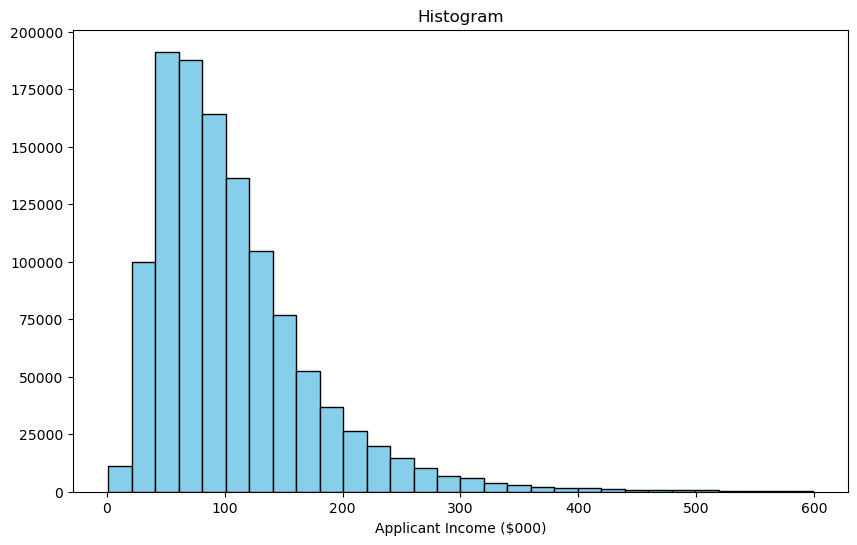

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(df_copy_2[df_copy_2['Applicant_Income_000'] < 600]['Applicant_Income_000'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Applicant Income ($000)')

In [40]:
check_income = quality_check(df_copy_2, 'Applicant_Income_000')
print("Negative Values", check_income['negative_values'].shape[0])
print(check_income['negative_values'])
print("\nNull Values", check_income['null_values'].shape[0])
print(check_income['null_values'])
print("\nNon-numeric Values", check_income['not_numeric_values'].shape[0])
print(check_income['not_numeric_values'])
print("\nOutliers", check_income['outliers'].shape[0])
print(check_income['outliers'])
print("\nCompleteness Percentage")
print(check_income['completeness'])

Negative Values 0
Series([], Name: Applicant_Income_000, dtype: float64)

Null Values 115027
695       NaN
774       NaN
807       NaN
810       NaN
1023      NaN
           ..
1320737   NaN
1320770   NaN
1320784   NaN
1320791   NaN
1320823   NaN
Name: Applicant_Income_000, Length: 115027, dtype: float64

Non-numeric Values 0
Series([], Name: Applicant_Income_000, dtype: float64)

Outliers 50799
63        396.00
67        335.00
80        337.00
81        270.00
101       258.00
           ...  
1320139   277.00
1320359   260.00
1320361   336.00
1320530   300.00
1320750   490.00
Name: Applicant_Income_000, Length: 50799, dtype: float64

Completeness Percentage
91.02875972468657


In [41]:
existing_indexes = set(df_copy_2.index)
indexes_to_drop = set(check_income['outliers'].index)
indexes_final = existing_indexes.intersection(indexes_to_drop)

df_copy_2 = df_copy_2.drop(list(indexes_final))
print(df_copy_2.shape)
df_copy_2.head(10)

(1231376, 26)


,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Lien_Status_Description,Loan_Type_Description,State,County_Name,Conforming_Limit_000,Conventional_Status,Conforming_Status,Conventional_Conforming_Flag,Respondent_Name_TS,Loan_Group
0,3,84.00,2012,207.00,79.00,54900.00,94,16620.00,1545.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
1,3,84.00,2012,9556.00,43.00,54900.00,133,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
2,3,53.00,2012,9556.00,43.00,54900.00,70,16620.00,1548.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
3,3,85.00,2012,206.01,79.00,54900.00,102,16620.00,1935.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
4,3,38.00,2012,107.01,39.00,54900.00,112,16620.00,1492.00,384,...,First Lien,Conventional,WV,KANAWHA,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
5,3,113.00,2012,206.05,79.00,54900.00,133,16620.00,2493.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
6,3,91.00,2012,9555.00,43.00,54900.00,192,16620.00,1173.00,384,...,First Lien,Conventional,WV,LINCOLN,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Medium
7,3,25.00,2012,121.00,39.00,54900.00,36,16620.00,1361.00,384,...,First Lien,Conventional,WV,KANAWHA,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small
8,3,111.00,2012,19.02,39.00,54900.00,191,16620.00,1552.00,384,...,First Lien,Conventional,WV,KANAWHA,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Medium
9,3,70.00,2012,206.05,79.00,54900.00,110,16620.00,2493.00,384,...,First Lien,Conventional,WV,PUTNAM,417.00,Conventional,Conforming,Y,THE OHIO VALLEY BANK COMPANY,Small


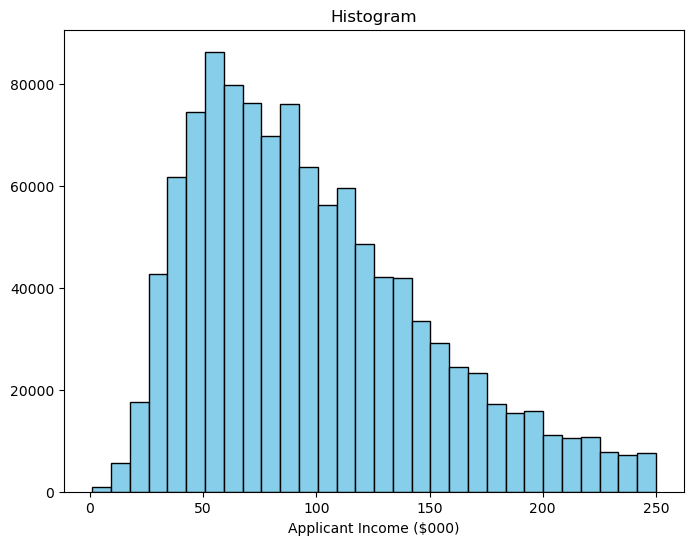

In [42]:
plt.figure(figsize = (8,6))
plt.hist(df_copy_2['Applicant_Income_000'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Applicant Income ($000)')
plt.show()

In [43]:
median_income = df['Applicant_Income_000'].median()
df['Applicant_Income_000'] = df['Applicant_Income_000'].fillna(median_income)

After analyzing our variable 'Applicant_Income_000', we have decided to impute the median for missing values. This approach ensures that we do not lose data and work with the highest possible level of completeness.

* Uniqueness Primary Key

The 'Data Challenge - Metadata' document mentions that combining the variables 'As_of_Year', 'Agency_Code', and 'Respondent_ID' can serve as a unique identifier for the institution for that year. Therefore, we need to ensure that our database of institutions has no duplicates in this set of variables.

In [44]:
def quality_check_3(df, column_name):
    null_sum = df[column_name].isnull().sum()
    completeness = (1-null_sum/df.shape[0])*100
    return completeness

In [45]:
print(quality_check_3(df_copy_2, 'As_of_Year'))
print(quality_check_3(df_copy_2, 'Agency_Code'))
print(quality_check_3(df_copy_2, 'Respondent_ID'))

100.0
100.0
100.0


In [46]:
#Check for one digit
df_copy_2[~df_copy_2['Agency_Code'].astype(str).str.match(r'^\d$')].shape[0]

0

In [47]:
print('Unique years in the dataset:',df['As_of_Year'].unique())

Unique years in the dataset: [2012 2013 2014]


In [48]:
df_copy_2['Identifier'] = df_copy_2['As_of_Year'].astype(str) + "_" + df_copy_2['Agency_Code'].astype(str) + "_" + df_copy_2['Respondent_ID'].astype(str)
df_copy_2['Identifier']

0                 2012_3_384
1                 2012_3_384
2                 2012_3_384
3                 2012_3_384
4                 2012_3_384
                 ...        
1320853    2014_7_95-4623407
1320854    2014_7_95-4623407
1320855    2014_7_95-4623407
1320856    2014_7_95-4623407
1320857    2014_7_95-4866828
Name: Identifier, Length: 1231376, dtype: object

We have verified that our institution database is $100\%$ complete and that the 'Agency_Code' attribute is a single digit. Finally, we created a new column combining these attributes.

3.	Create a visual narrative with data

The dataset only contains information from five states: West Virginia, Delaware, District of Columbia, Maryland, and Virginia. Based on this information, we propose the following hypothesis:

##### Hypothesis

Entering the Maryland market is currently the best option for Keep Financial, as there has been a positive trend in mortgage loans and stable incomes over the past few years.

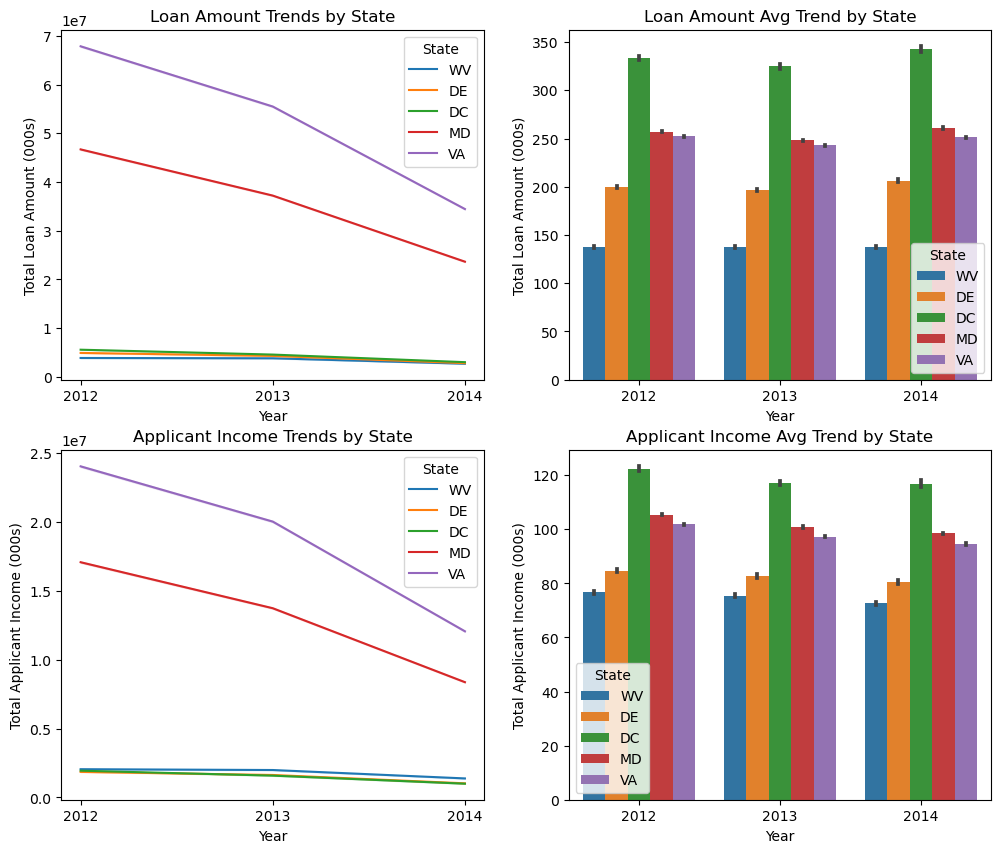

In [49]:
plt.figure(figsize=(12, 10))

df_copy_3 = df_copy_2.copy()
df_copy_3['As_of_Year'] = df_copy_3['As_of_Year'].astype(str)

plt.subplot(2, 2, 1)
sns.lineplot(x='As_of_Year', y='Loan_Amount_000', hue='State', data=df_copy_3, estimator = sum)
plt.title('Loan Amount Trends by State')
plt.xlabel('Year')
plt.ylabel('Total Loan Amount (000s)')
plt.legend(title='State')

plt.subplot(2, 2, 2)
sns.barplot(x='As_of_Year', y='Loan_Amount_000', hue='State', data=df_copy_3)
plt.title('Loan Amount Avg Trend by State')
plt.xlabel('Year')
plt.ylabel('Total Loan Amount (000s)')
plt.legend(title='State')

plt.subplot(2, 2, 3)
sns.lineplot(x='As_of_Year', y='Applicant_Income_000', hue='State', data=df_copy_3, estimator = sum)
plt.title('Applicant Income Trends by State')
plt.xlabel('Year')
plt.ylabel('Total Applicant Income (000s)')
plt.legend(title='State')

plt.subplot(2, 2, 4)
sns.barplot(x='As_of_Year', y='Applicant_Income_000', hue='State', data=df_copy_3)
plt.title('Applicant Income Avg Trend by State')
plt.xlabel('Year')
plt.ylabel('Total Applicant Income (000s)')
plt.legend(title='State')

plt.show()

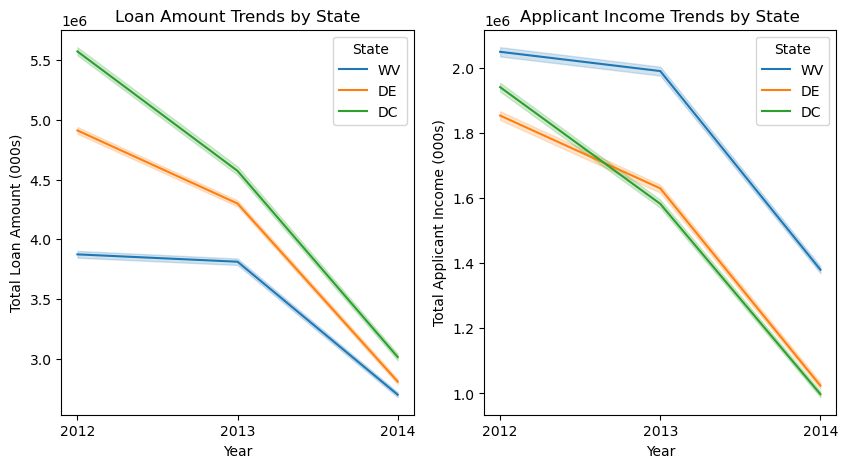

In [50]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x='As_of_Year', y='Loan_Amount_000', hue='State', data=df_copy_3[df_copy_3['State'].isin(['DC', 'DE', 'WV'])], estimator = sum)
plt.title('Loan Amount Trends by State')
plt.xlabel('Year')
plt.ylabel('Total Loan Amount (000s)')
plt.legend(title='State')

plt.subplot(1, 2, 2)
sns.lineplot(x='As_of_Year', y='Applicant_Income_000', hue='State', data=df_copy_3[df_copy_3['State'].isin(['DC', 'DE', 'WV'])], estimator = sum)
plt.title('Applicant Income Trends by State')
plt.xlabel('Year')
plt.ylabel('Total Applicant Income (000s)')
plt.legend(title='State')

plt.show()

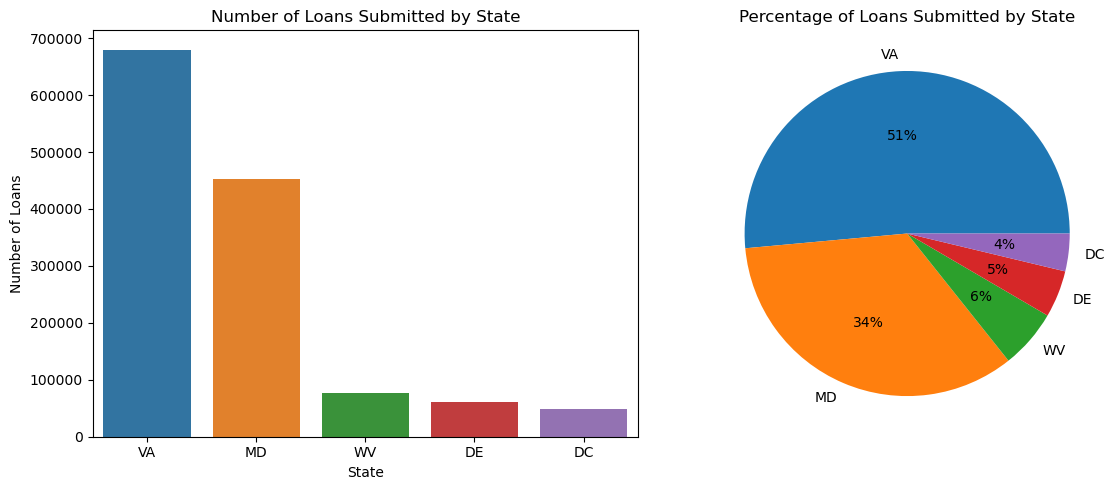

In [51]:
plt.figure(figsize=(12, 5))
loans_per_state = df['State'].value_counts().reset_index()
loans_per_state.columns = ['State', 'Number_of_Loans']

plt.subplot(1, 2, 1)
sns.barplot(x='State', y='Number_of_Loans', data=loans_per_state)
plt.title('Number of Loans Submitted by State')
plt.xlabel('State')
plt.ylabel('Number of Loans')

plt.subplot(1, 2, 2)

plt.pie(x=loans_per_state['Number_of_Loans'], labels=loans_per_state['State'], autopct='%.0f%%')
plt.title('Percentage of Loans Submitted by State')

plt.tight_layout()
plt.show()

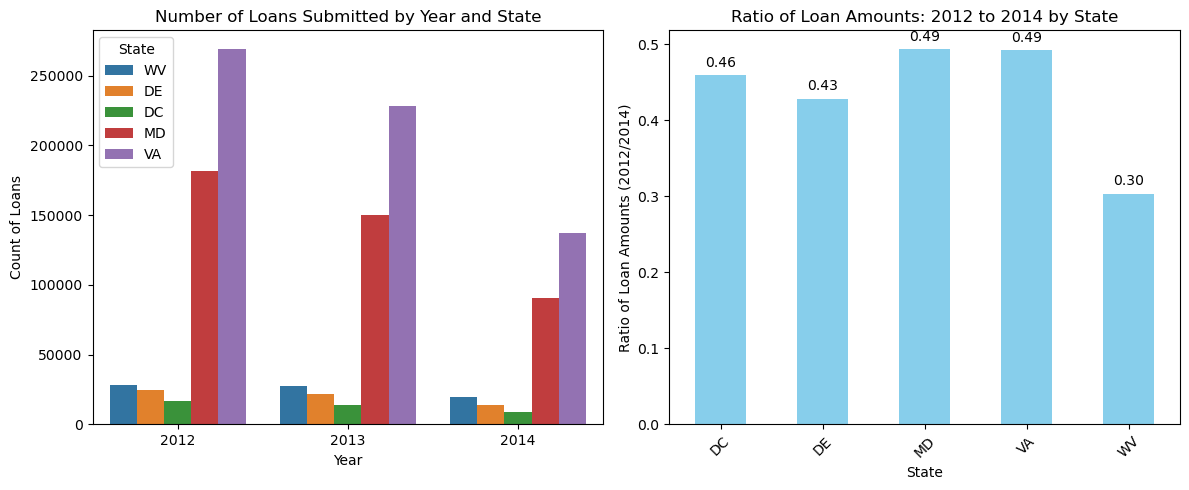

In [52]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(
    x='As_of_Year',
    hue='State',
    data=df_copy_2
)
ax1.set_title('Number of Loans Submitted by Year and State')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count of Loans')
plt.legend(loc='upper left', title='State')


df_agg = df_copy_3[['As_of_Year', 'State', 'Loan_Amount_000', 'Applicant_Income_000']].groupby(['As_of_Year', 'State']).sum()
df_agg.reset_index(inplace = True)
df_pivot = df_agg.pivot(index='State', columns='As_of_Year', values='Loan_Amount_000')
df_pivot['Ratio_2012_to_2014'] = 1 - df_pivot['2014'] / df_pivot['2012']

plt.subplot(1, 2, 2)
ax = df_pivot['Ratio_2012_to_2014'].plot(kind='bar', color='skyblue')
plt.title('Ratio of Loan Amounts: 2012 to 2014 by State')
plt.xlabel('State')
plt.ylabel('Ratio of Loan Amounts (2012/2014)')
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

D:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\erics\AppData\Local\Temp\ipykernel_29872\2386926625.py:13: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


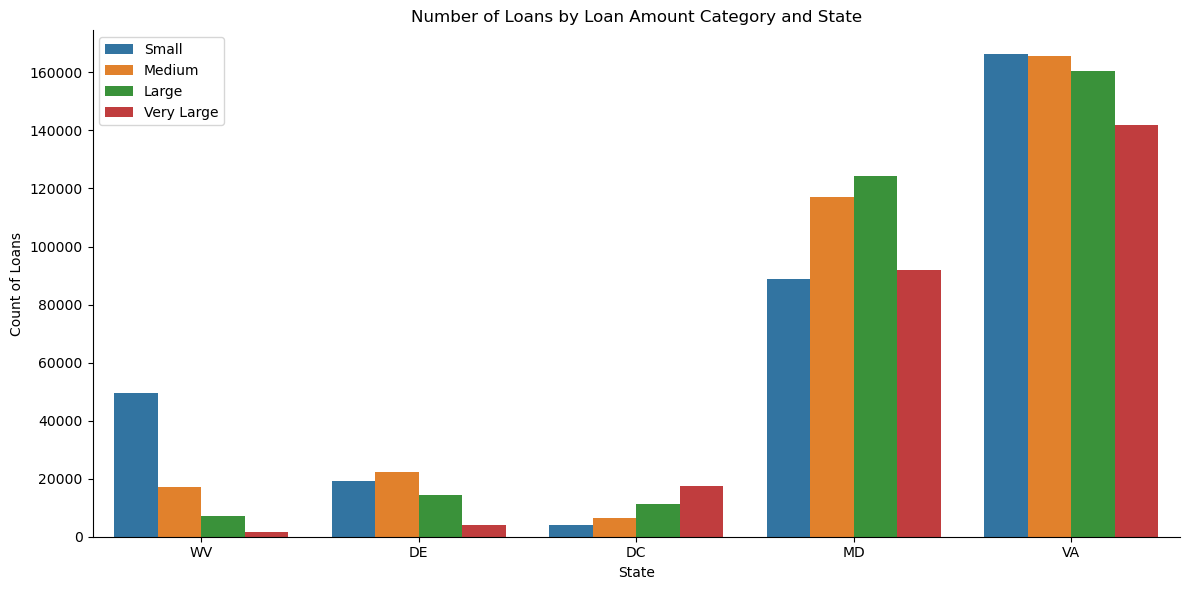

In [57]:
g = sns.catplot(
    x='State', 
    kind='count', 
    hue='Loan_Group', 
    data=df_copy_2, 
    height=6, 
    aspect=2,
    legend = False
)

g.ax.set_title('Number of Loans by Loan Amount Category and State')
g.set_axis_labels('State', 'Count of Loans')
g.fig.tight_layout()

plt.legend(loc='upper left')
plt.show()

Text(0.5, 1.0, 'Number of Refinance and Purchase')

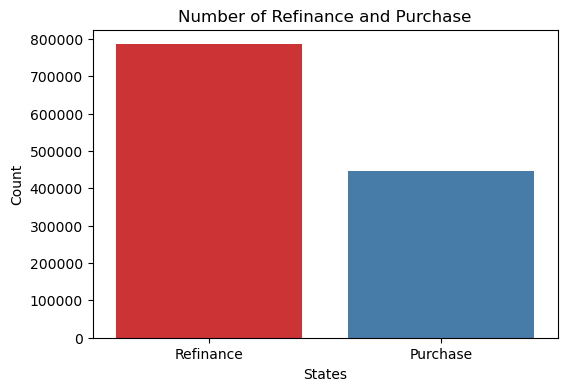

In [54]:
plt.figure(figsize=(6,4))
sns.countplot(x ='Loan_Purpose_Description', data = df_copy_2, palette = 'Set1')
plt.ylabel('Count')
plt.xlabel('States')
plt.title('Number of Refinance and Purchase')

D:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\erics\AppData\Local\Temp\ipykernel_29872\4202374012.py:13: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


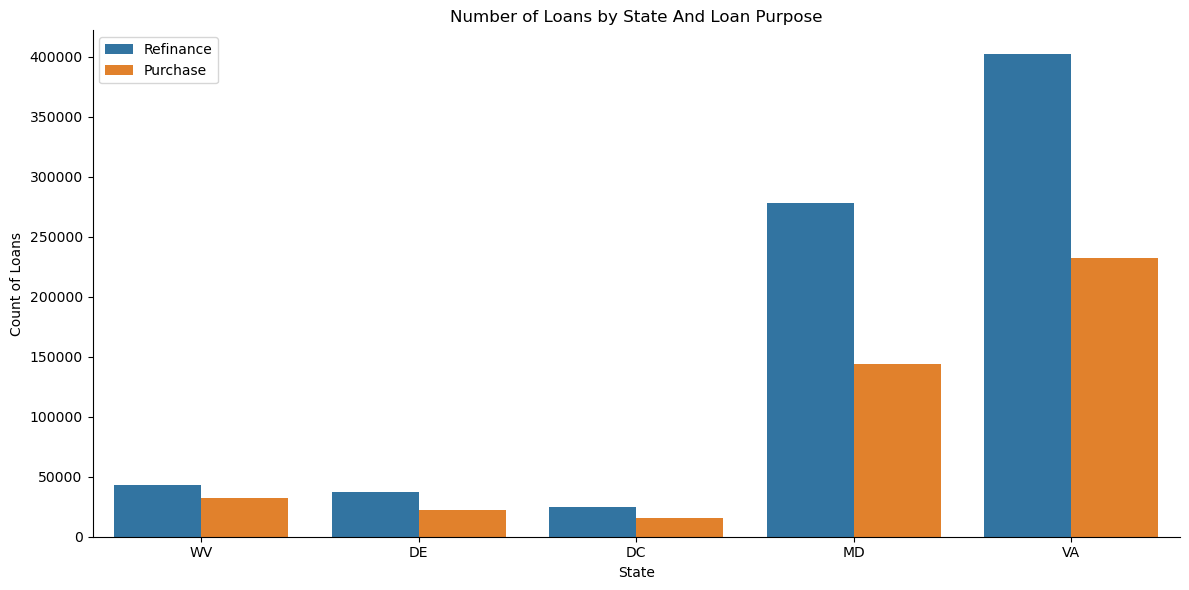

In [59]:
g = sns.catplot(
    x='State', 
    kind='count', 
    hue='Loan_Purpose_Description', 
    data=df_copy_2, 
    height=6, 
    aspect=2,
    legend = False
)

g.ax.set_title('Number of Loans by State And Loan Purpose')
g.set_axis_labels('State', 'Count of Loans')
g.fig.tight_layout()
plt.legend(loc='upper left')
plt.show()

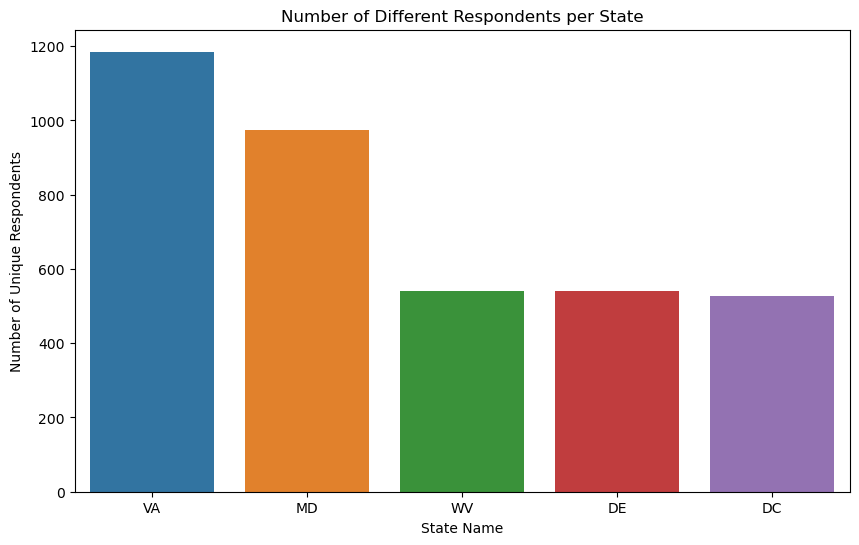

In [56]:
respondent_per_state = df.groupby('State')['Respondent_Name_TS'].nunique().reset_index()
respondent_per_state_sorted = respondent_per_state.sort_values(by='Respondent_Name_TS', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=respondent_per_state_sorted, x='State', y='Respondent_Name_TS')
plt.title('Number of Different Respondents per State')
plt.xlabel('State Name')
plt.ylabel('Number of Unique Respondents')
plt.show()

There is a downward trend in the loan amounts requested, with Maryland being the second in this category. At the same time, the average loan amount and applicant income rank second, with District of Columbia first and Virginia third.

In terms of the number of applications, Virginia leads, followed by Maryland, with West Virginia, Delaware, and District of Columbia trailing significantly. Virginia has strong numbers in both the total sum of loans and demand, making it the largest market among these states.

The majority of loan applications are for property refinancing, a trend consistent across all states. Regarding loan amounts by category, the relationship with the states is very similar, except for the District of Columbia, where the highest percentage is in high-level loans, reflected in the average loan amount.

After this analysis, we can conclude that Maryland is a good option due to the market it offers. However, better opportunities may exist depending on the company's needs, such as in the state of Virginia. Further analyses are needed, including additional loan characteristics, to make a well-informed decision.

4.	Basic stuff is done, now go a step further. What have piqued your mind so far? Have any worries about data quality? Make hypothesis, prototype a tool to improve this data product and highlight your area of expertise.

We will begin by cleaning the variables 'Loan_Amount_000' and 'Applicant_Income_000', identifying and removing data that could affect our decisions to ensure a higher quality analysis.

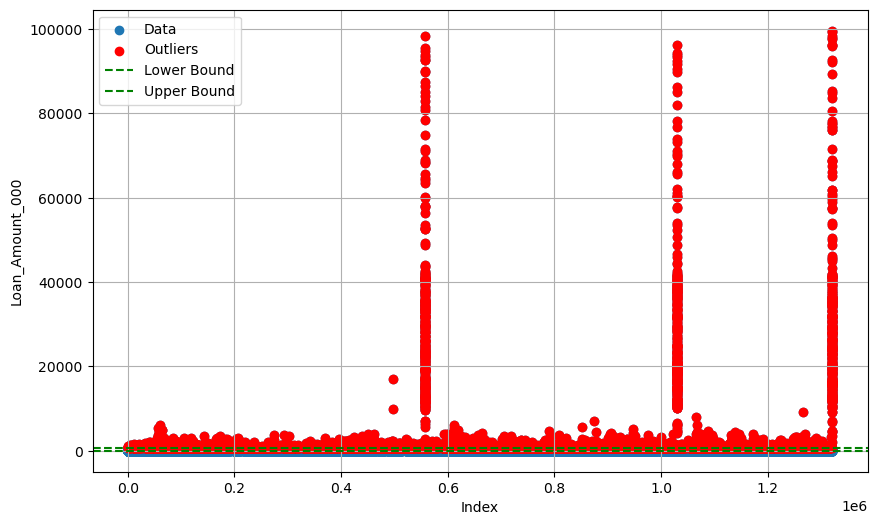

Button(description='Remove Outliers', style=ButtonStyle())

D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


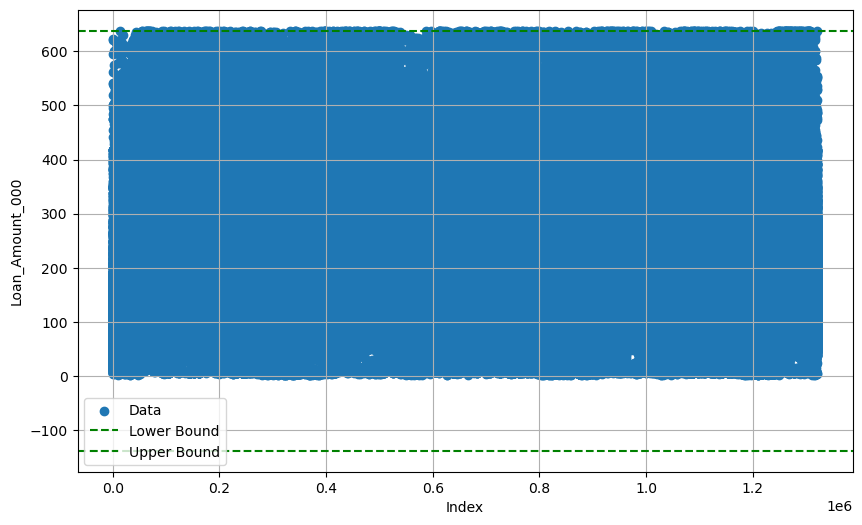

In [60]:
def get_outliers(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_outliers = df.loc[(df[column_name] < fence_low) | (df[column_name] > fence_high)]
    return df_outliers, fence_low, fence_high

def plot_data(df, outliers, column_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[column_name], label='Data')
    if not outliers.empty:
        plt.scatter(outliers.index, outliers[column_name], color='r', label='Outliers')
    plt.axhline(y=fence_low, color='g', linestyle='--', label='Lower Bound')
    plt.axhline(y=fence_high, color='g', linestyle='--', label='Upper Bound')
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def remove_outliers(b):
    global df_copy_5
    global outliers
    df_copy_5 = df_copy_5.loc[(df_copy_5['Loan_Amount_000'] >= fence_low) & (df_copy_5['Loan_Amount_000'] <= fence_high)]
    outliers = pd.DataFrame(columns = df_copy_5.columns)
    plot_data(df_copy_5, outliers, 'Loan_Amount_000')

df_copy_5 = df.copy()
outliers, fence_low, fence_high = get_outliers(df_copy_5, 'Loan_Amount_000')
plot_data(df_copy_5, outliers, 'Loan_Amount_000')

button = widgets.Button(description="Remove Outliers")
button.on_click(remove_outliers)
display(button)

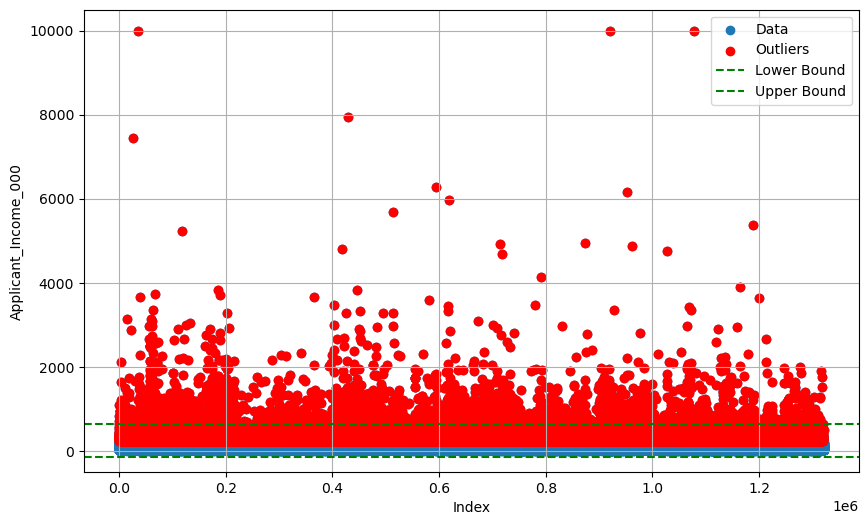

Button(description='Remove Outliers', style=ButtonStyle())

D:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


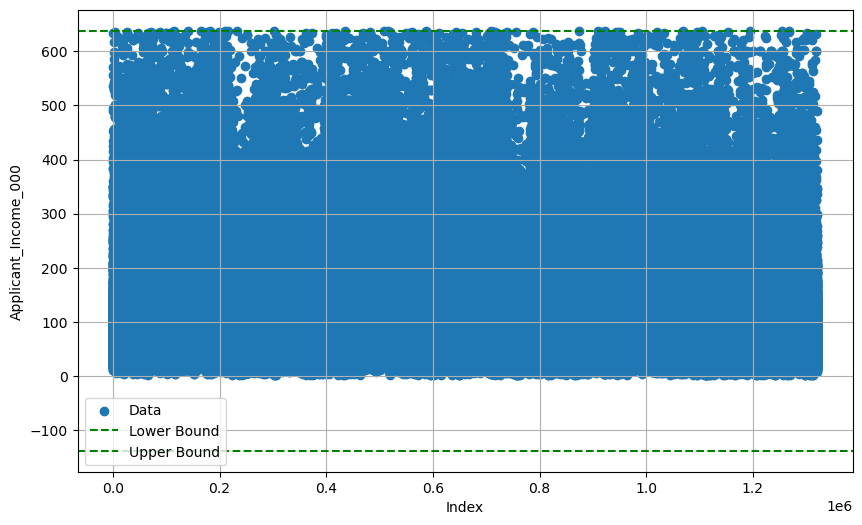

In [61]:
def remove_outliers_2(b):
    global df_copy_5
    global outliers_2
    df_copy_5 = df_copy_5.loc[(df_copy_5['Applicant_Income_000'] >= fence_low) & (df_copy_5['Applicant_Income_000'] <= fence_high)]
    outliers_2 = pd.DataFrame(columns = df_copy_5.columns)
    plot_data(df_copy_5, outliers_2, 'Applicant_Income_000')

outliers_2, fence_low_2, fence_high_2 = get_outliers(df_copy_5, 'Applicant_Income_000')
plot_data(df_copy_5, outliers_2, 'Applicant_Income_000')

button = widgets.Button(description="Remove Outliers")
button.on_click(remove_outliers_2)
display(button)

In [62]:
def update_plot(state):
    filtered_data = df_copy_2[df_copy_2['State'] == state]
    
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_data['Loan_Amount_000'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Loan Amount Distribution in {state}')
    plt.xlabel('Loan Amount (000s)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

state_dropdown = widgets.Dropdown(
    options=['VA', 'MD', 'DC', 'WV', 'DE'],
    value='VA',
    description='State:',
    disabled=False,
)

widgets.interactive(update_plot, state=state_dropdown)

interactive(children=(Dropdown(description='State:', options=('VA', 'MD', 'DC', 'WV', 'DE'), value='VA'), Outp…

A continuación realizaremos la limpieza de las variables de tipo cadena, donde ajustaremos un estándar para los datos y sea más fácil la manipulación de estas variables.

In [63]:
def clean_data(b):
    column_name = dropdown.value
    df_copy_5[column_name] = df_copy_5[column_name].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    df_copy_5[column_name] = df_copy_5[column_name].str.upper().str.strip()

    with output:
        clear_output(wait=True)
        display(df_copy_5)

dropdown = widgets.Dropdown(
    options=df_copy_5.columns,
    description='Column:',
    disabled=False
)

button = widgets.Button(description="Clean Data")

output = widgets.Output()
button.on_click(clean_data)

display(dropdown, button, output)

Dropdown(description='Column:', options=('Agency_Code', 'Applicant_Income_000', 'As_of_Year', 'Census_Tract_Nu…

Button(description='Clean Data', style=ButtonStyle())

Output()

Finally, we will review variables with incomplete values and decide whether to remove records with missing information.

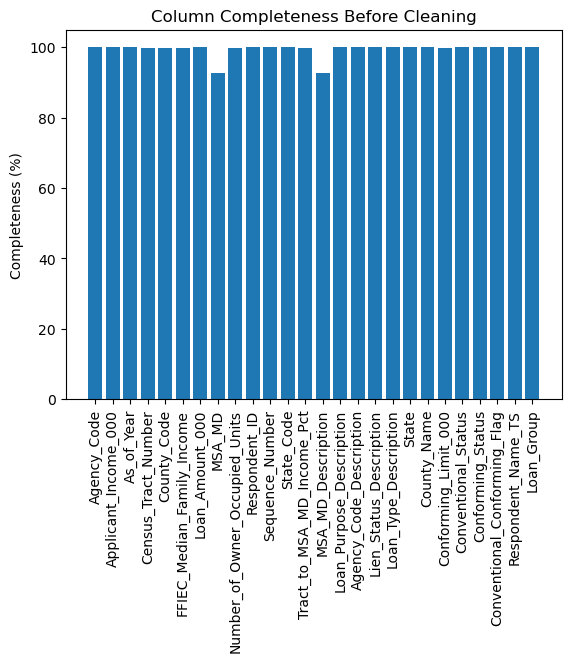

Dropdown(description='Column:', options=('Agency_Code', 'Applicant_Income_000', 'As_of_Year', 'Census_Tract_Nu…

Button(description='Remove Nulls', style=ButtonStyle())

In [64]:
def plot_completeness(df):
    completeness = df.notnull().mean() * 100 
    plt.bar(completeness.index, completeness)
    plt.ylabel('Completeness (%)')
    plt.title('Column Completeness Before Cleaning')
    plt.xticks(rotation=90)
    plt.show()

def remove_nulls(b):
    selected_column = dropdown.value
    global df_copy_5
    df_copy_5 = df_copy_5[df_copy_5[selected_column].notnull()] 

    clear_output(wait=True)
    display(dropdown, button)
    plot_completeness(df_copy_5)

plot_completeness(df_copy_5)

dropdown = widgets.Dropdown(
    options=df_copy_5.columns,
    value=df_copy_5.columns[0],
    description='Column:',
    disabled=False,
)

button = widgets.Button(description="Remove Nulls")
button.on_click(remove_nulls)

display(dropdown, button)

### Virginia vs West Virginia

##### Hypothesis

Virginia will show a greater ratio between borrowers' incomes and the loan amounts requested compared to West Virginia, reflecting a less expensive real estate market in West Virginia and lower property prices.

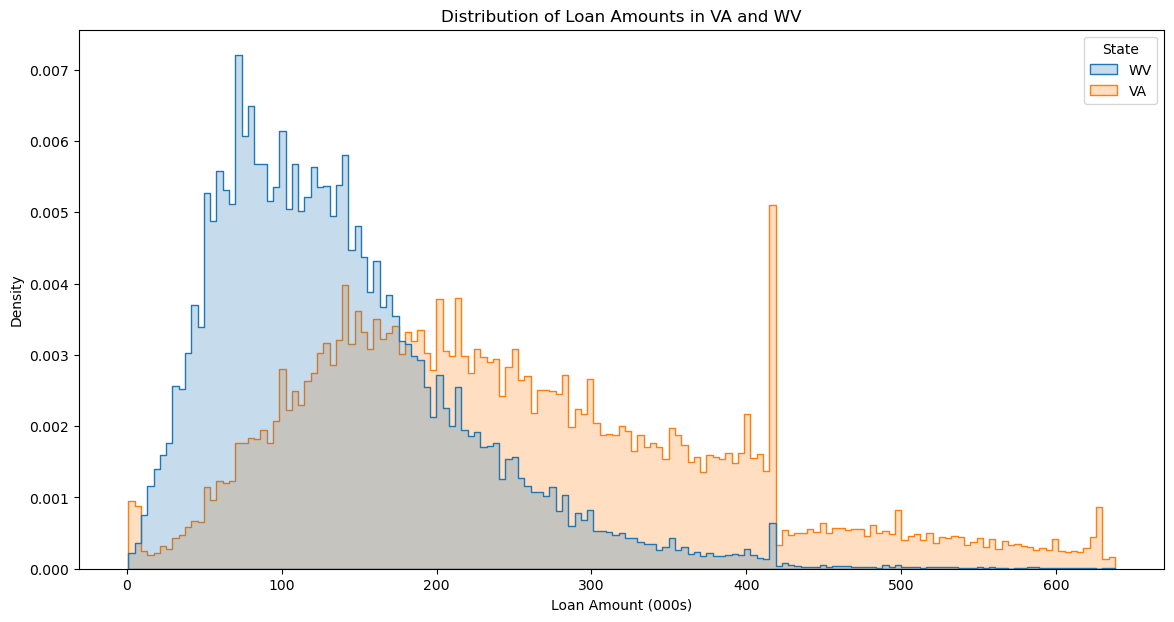

In [65]:
plt.figure(figsize=(14, 7))
sns.histplot(data=df_copy_2[df_copy_2['State'].isin(['VA', 'WV'])], x='Loan_Amount_000', hue='State', element='step', stat='density', common_norm=False)
plt.title('Distribution of Loan Amounts in VA and WV')
plt.xlabel('Loan Amount (000s)')
plt.ylabel('Density')
plt.show()

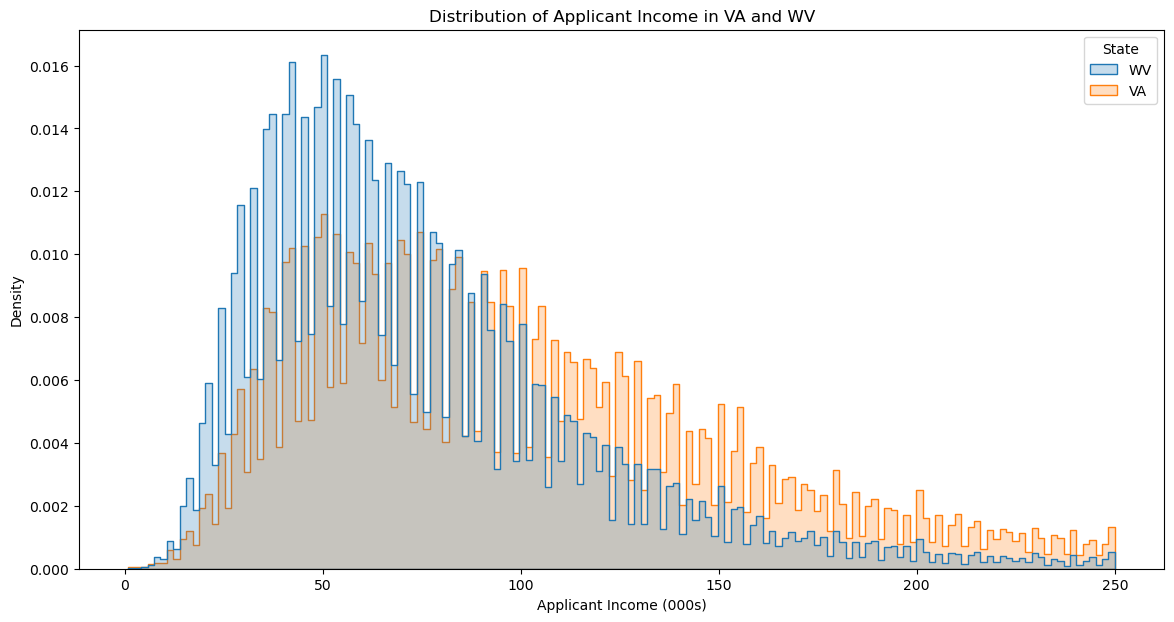

In [66]:
plt.figure(figsize=(14, 7))
sns.histplot(data=df_copy_2[df_copy_2['State'].isin(['VA', 'WV'])], x='Applicant_Income_000', hue='State', element='step', stat='density', common_norm=False)
plt.title('Distribution of Applicant Income in VA and WV')
plt.xlabel('Applicant Income (000s)')
plt.ylabel('Density')
plt.show()

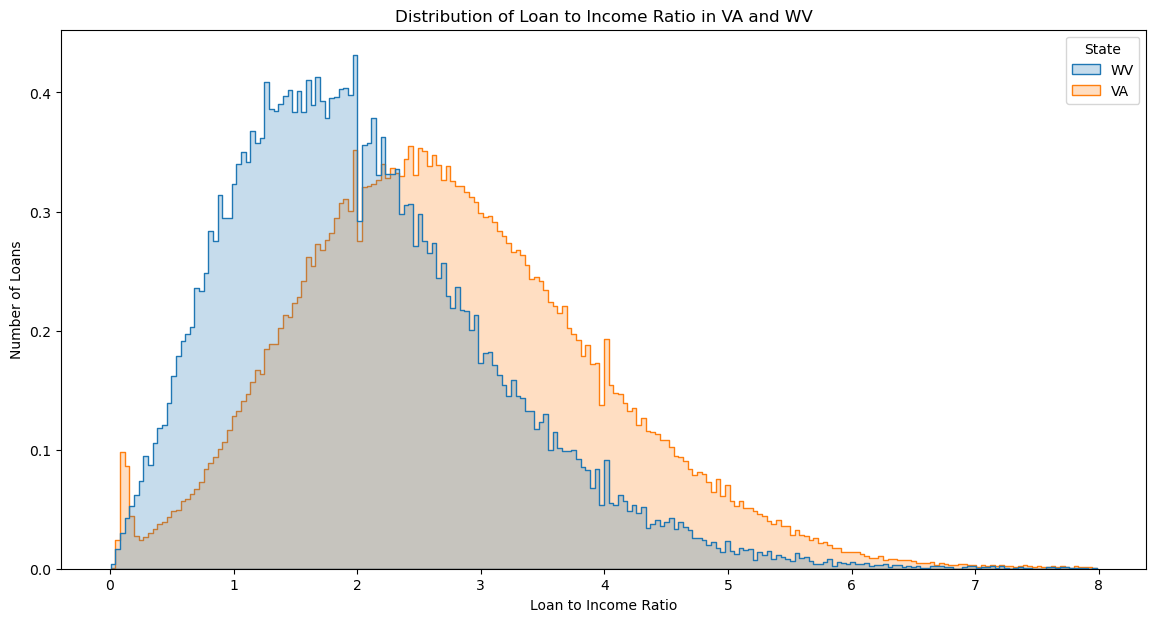

In [67]:
df_copy_4 = df_copy_2.copy()
df_copy_4['Loan_to_Income_Ratio'] = df_copy_4['Loan_Amount_000'] / df_copy_4['Applicant_Income_000']

plt.figure(figsize=(14, 7))
sns.histplot(data=df_copy_4[df_copy_4['State'].isin(['VA', 'WV'])  & (df_copy_4['Loan_to_Income_Ratio'] < 8)], x='Loan_to_Income_Ratio', hue='State', element='step', stat='density', common_norm=False)
plt.title('Distribution of Loan to Income Ratio in VA and WV')
plt.xlabel('Loan to Income Ratio')
plt.ylabel('Number of Loans')
plt.show()

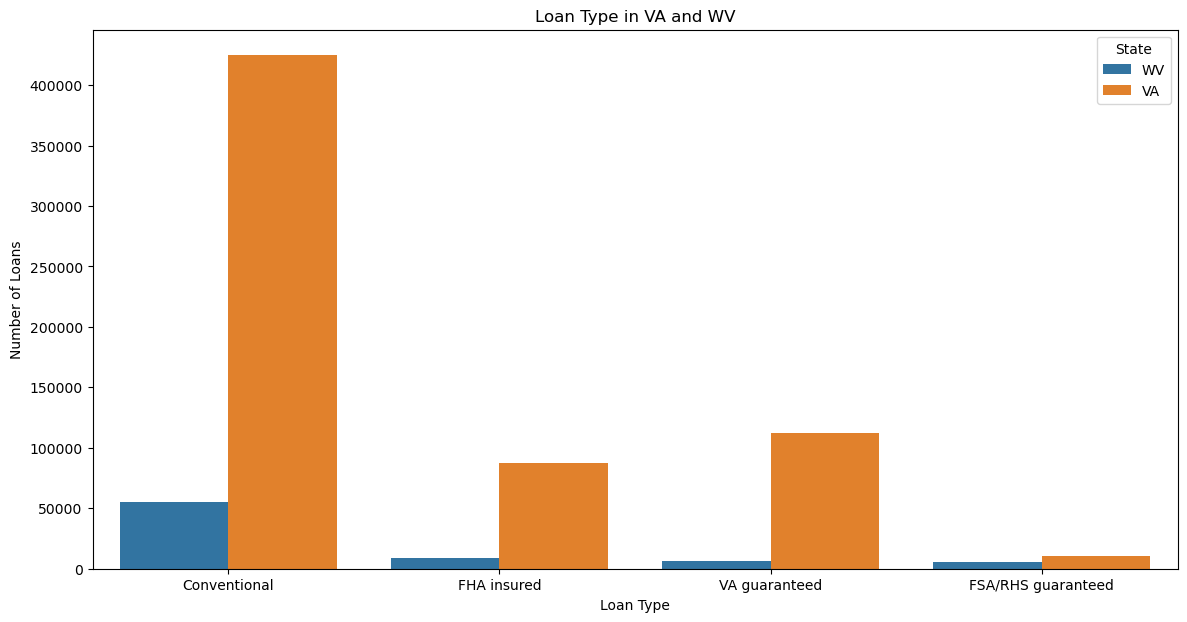

In [68]:
plt.figure(figsize=(14, 7))
sns.countplot(data=df_copy_2[df_copy_2['State'].isin(['VA', 'WV'])], x='Loan_Type_Description', hue='State')
plt.title('Loan Type in VA and WV')
plt.xlabel('Loan Type')
plt.ylabel('Number of Loans')
plt.show()

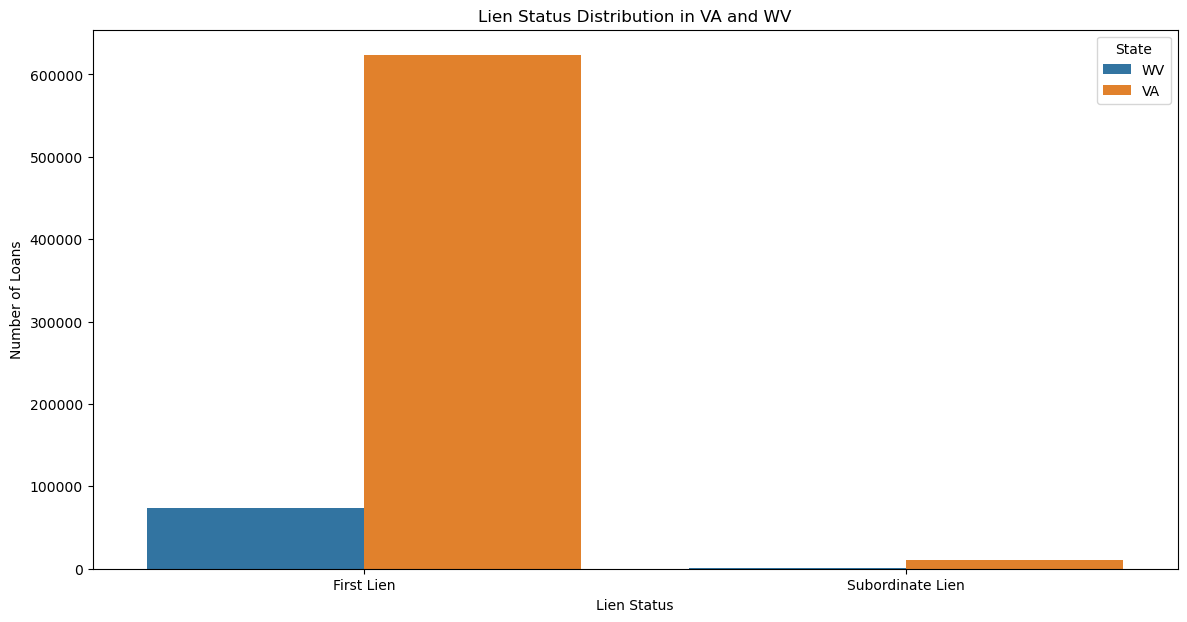

In [69]:
plt.figure(figsize=(14, 7))
sns.countplot(data=df_copy_2[df_copy_2['State'].isin(['VA', 'WV'])], x='Lien_Status_Description', hue='State')
plt.title('Lien Status Distribution in VA and WV')
plt.ylabel('Number of Loans')
plt.xlabel('Lien Status')
plt.show()

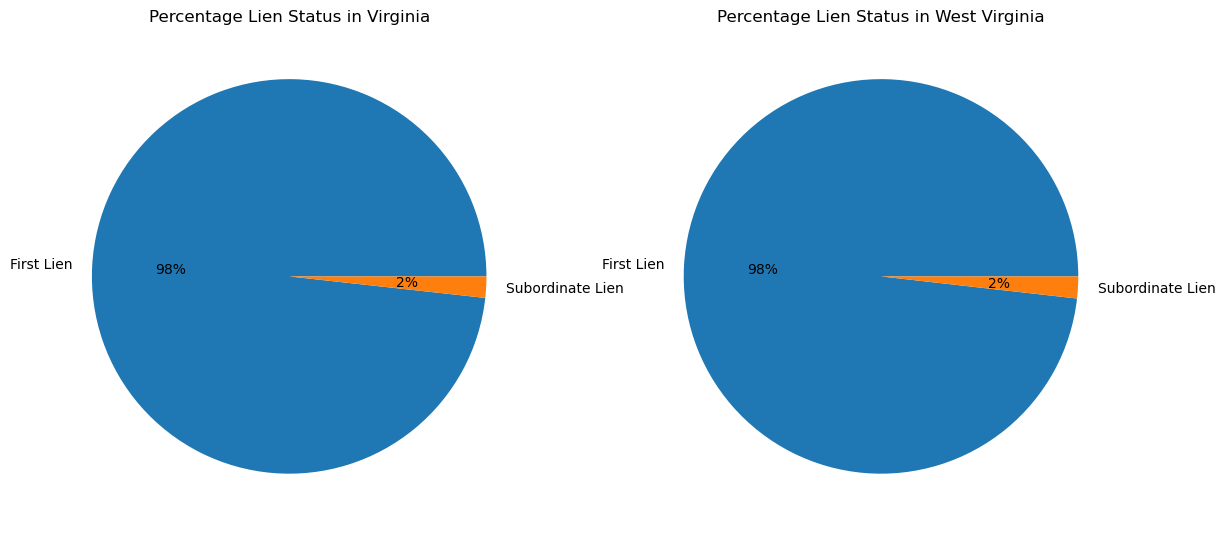

In [70]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.pie(x=df_copy_2[df_copy_2['State'].isin(['VA'])]['Lien_Status_Description'].value_counts(normalize=True), labels=['First Lien', 'Subordinate Lien'], autopct='%.0f%%')
plt.title('Percentage Lien Status in Virginia')

plt.subplot(1, 2, 2)
plt.pie(x=df_copy_2[df_copy_2['State'].isin(['WV'])]['Lien_Status_Description'].value_counts(normalize=True), labels=['First Lien', 'Subordinate Lien'], autopct='%.0f%%')
plt.title('Percentage Lien Status in West Virginia')

plt.show()

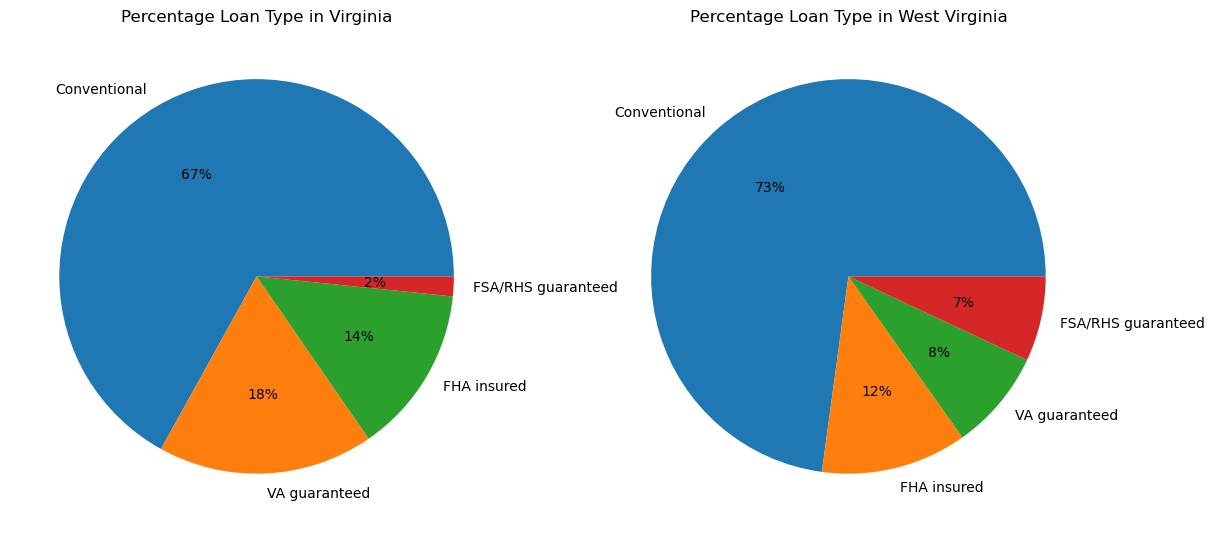

In [71]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.pie(x=df_copy_2[df_copy_2['State'].isin(['VA'])]['Loan_Type_Description'].value_counts(normalize=True), labels=df_copy_2[df_copy_2['State'].isin(['VA'])]['Loan_Type_Description'].value_counts(normalize=True).index, autopct='%.0f%%')
plt.title('Percentage Loan Type in Virginia')

plt.subplot(1, 2, 2)
plt.pie(x=df_copy_2[df_copy_2['State'].isin(['WV'])]['Loan_Type_Description'].value_counts(normalize=True), labels=df_copy_2[df_copy_2['State'].isin(['WV'])]['Loan_Type_Description'].value_counts(normalize=True).index, autopct='%.0f%%')
plt.title('Percentage Loan Type in West Virginia')

plt.show()

Our investigation revealed that the loan-to-income ratio differs between Virginia and West Virginia, validating our initial hypothesis of significant differences. The analysis highlighted factors such as higher income among middle and upper-income applicants in Virginia and a higher volume of veteran loans in Virginia. These results suggest that while the relative debt burden is comparable, underlying demographic and economic characteristics vary and should be considered in our market strategies. Thus, while our hypothesis holds in terms of loan-to-income ratio differences, the data underscore specific strategic opportunities in each state, such as focusing marketing efforts on specialized veteran products in Virginia and developing products for lower-income borrowers in West Virginia.

### Model

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [129]:
df_copy_2.dropna(inplace = True)
df_copy_model = df_copy_2.copy()
df_copy_model.drop(columns = ['Agency_Code', 'As_of_Year', 'Agency_Code_Description', 'Respondent_ID', 'Sequence_Number',
                              'State_Code', 'MSA_MD_Description', 'Census_Tract_Number', 'Tract_to_MSA_MD_Income_Pct', 
                              'FFIEC_Median_Family_Income', 'Number_of_Owner_Occupied_Units', 'County_Name', 'County_Code',
                              'Conforming_Limit_000', 'Conventional_Conforming_Flag', 'Identifier', 
                              'As_of_Year', 'Respondent_Name_TS', 'FFIEC_Median_Family_Income', 'MSA_MD',
                              'Loan_Group','Conventional_Status', 'Lien_Status_Description', 'Conforming_Status',
                              'Applicant_Income_000'], inplace = True, axis = 0)
df_copy_model.reset_index(drop=True, inplace=True)
df_copy_model.columns

Index(['Loan_Amount_000', 'Loan_Purpose_Description', 'Loan_Type_Description',
       'State'],
      dtype='object')

In [133]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_copy_model[['Loan_Purpose_Description', 
                                                        'Loan_Type_Description', 'State',]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
X = encoded_df
y = df_copy_model['Loan_Amount_000']

In [134]:
X.isnull().sum()

Loan_Purpose_Description_Purchase           0
Loan_Purpose_Description_Refinance          0
Loan_Type_Description_Conventional          0
Loan_Type_Description_FHA insured           0
Loan_Type_Description_FSA/RHS guaranteed    0
Loan_Type_Description_VA guaranteed         0
State_DC                                    0
State_DE                                    0
State_MD                                    0
State_VA                                    0
State_WV                                    0
dtype: int64

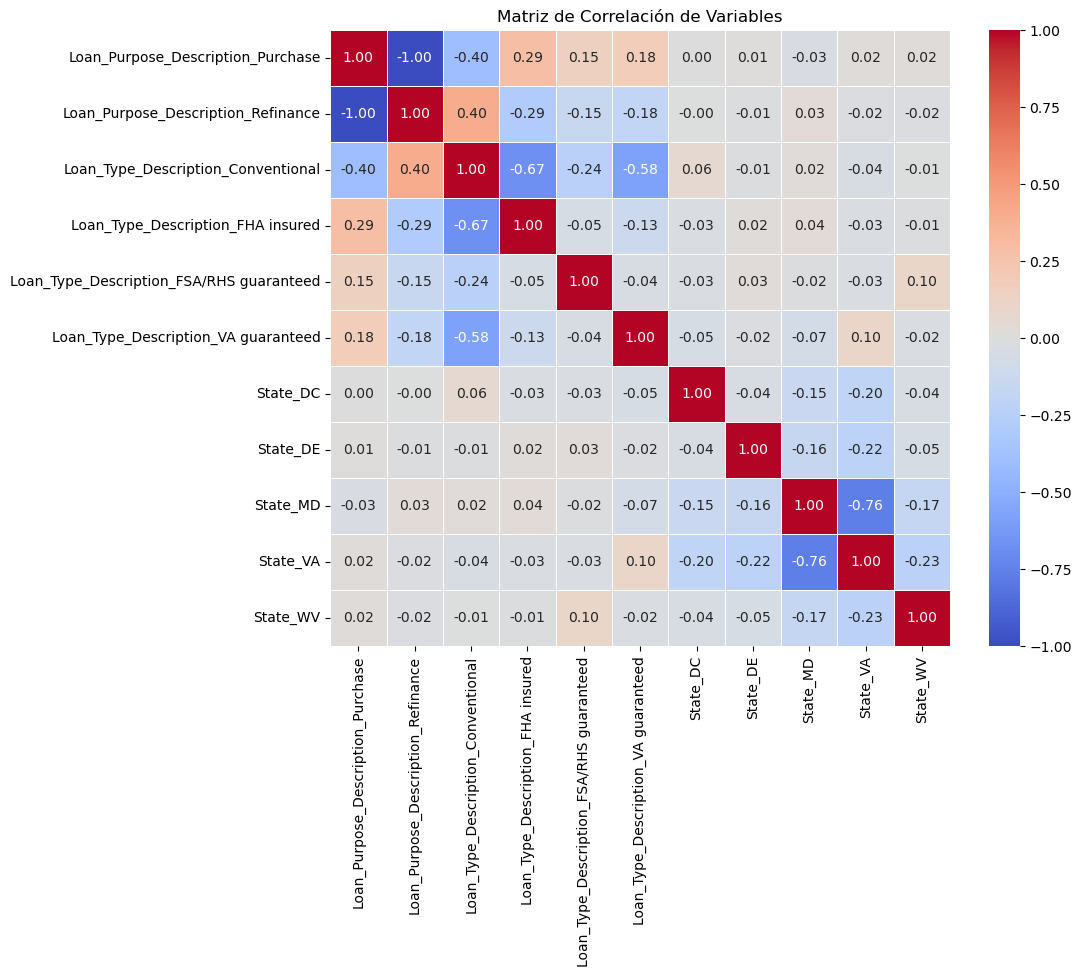

In [135]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=.5)
plt.title('Matriz de Correlación de Variables')
plt.show()

In [137]:
X.drop(columns = 'Loan_Purpose_Description_Refinance', inplace = True)
X.columns

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [141]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')

Mean Squared Error: 9199.675097002277
Mean Absolute Error: 74.09590477994202
R²: 0.44094880469201314


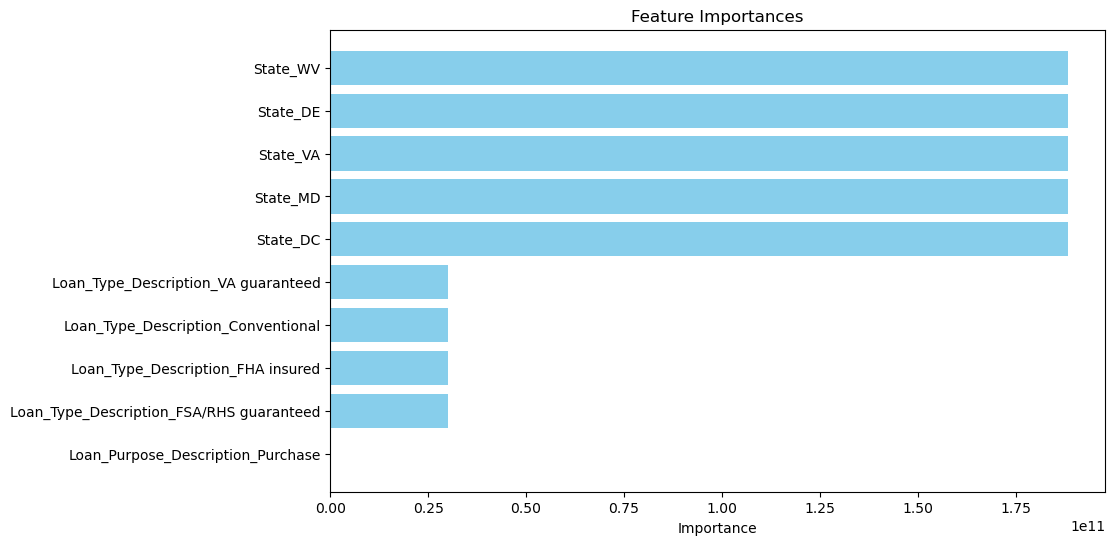

In [142]:
importances = model.coef_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(importances)
})

features = features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [143]:
print("Coeficientes del Modelo:")
print(pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}))

Coeficientes del Modelo:
                                    Feature      Coefficient
0         Loan_Purpose_Description_Purchase            31.94
1        Loan_Type_Description_Conventional   30143596354.09
2         Loan_Type_Description_FHA insured   30143596323.90
3  Loan_Type_Description_FSA/RHS guaranteed   30143596288.47
4       Loan_Type_Description_VA guaranteed   30143596397.59
5                                  State_DC -188385294405.17
6                                  State_DE -188385294537.97
7                                  State_MD -188385294481.89
8                                  State_VA -188385294487.23
9                                  State_WV -188385294592.94


In [146]:
features = ['Loan_Purpose_Description_Purchase','Loan_Type_Description_Conventional', 
            'Loan_Type_Description_FHA insured','Loan_Type_Description_FSA/RHS guaranteed', 
            'Loan_Type_Description_VA guaranteed',
            'State_DC', 'State_DE', 'State_MD', 'State_VA', 'State_WV']
df_scenarios = pd.DataFrame(columns=features)
df_scenarios.loc['West Virginia'] = [1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
df_scenarios.loc['Virginia'] = [1, 1, 0, 0, 0, 0, 0, 0, 1, 0]

predictions = model.predict(df_scenarios)

print("Predicciones de préstamo:")
print("West Virginia: ${:,.2f}".format(predictions[0]))
print("Virginia: ${:,.2f}".format(predictions[1]))

Predicciones de préstamo:
West Virginia: $135.77
Virginia: $271.68


With this model, we can create scenarios and foundations for the company corresponding to different states, estimating the total amount, loan volume, and the risk the company faces in different markets.

### Conclusion

The importance of choosing the right state lies in the specific product we plan to offer. By analyzing variables such as the type of loan—whether Conventional, FHA insured, FSA/RHS guaranteed, or VA guaranteed—we can identify which states have higher demand for each product. Additionally, by understanding the purpose of the loans, whether for home purchase or refinancing, we ensure that we are offering the correct product in the appropriate state.

Furthermore, using the loan-to-income ratio metric, we can assess the risk levels of different states in relation to their incomes. This metric will help us determine the type of risk we are willing to accept. The decision on which market to enter depends not only on the product characteristics but also on the current market conditions, as loan demand has decreased. Given that it is now 2014, a relatively short period after the 2008 financial crisis, understanding these dynamics is crucial.

This strategic approach will help us better align our offerings with the needs and demands of the target market, maximizing our potential for success in each state while carefully managing the associated risks.